In [1]:
from rockpool.devices.xylo.syns61201 import AFESim
from rockpool.timeseries import TSContinuous
import librosa
import numpy as np
import os
import logging
import matplotlib.pyplot as plt
import soundfile as sf
import pandas as pd

WARNING    /home/timon-l/devel/CITS5551/AcousticTrafficMonitoring/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 [py.warnings]
  from .autonotebook import tqdm as notebook_tqdm



In [ ]:
def audio_to_features(
    input_path: str,
    output_dir: str,
    label: int,
    target_sr: int = 16000,
    plot: bool = False
) -> str:
    fs = 110e3
    raster_period = 10e-3
    max_spike_per_raster_period = 15
    add_noise = False
    add_offset = False
    add_mismatch = False
    seed = None

    if not os.path.exists(input_path):
        logging.error(f"File does not exist: {input_path}")
        return ''

    y, sr = librosa.load(input_path, sr=target_sr, mono=True)

    dt = 1.0 / target_sr
    ts = TSContinuous.from_clocked(y, dt=dt, name='Audio input')

    afe = AFESim(
        fs=fs,
        raster_period=raster_period,
        max_spike_per_raster_period=max_spike_per_raster_period,
        add_noise=add_noise,
        add_offset=add_offset,
        add_mismatch=add_mismatch,
        seed=seed
    ).timed()

    features, stat, rec = afe(ts, record=True)
    raster = features.raster(dt=raster_period, add_events=True)

    if plot:
        fig, axs = plt.subplots(3, 1, figsize=(16, 12), sharex=False)

        time_axis = np.linspace(0, len(y) / sr, num=len(y))
        axs[0].plot(time_axis, y, linewidth=0.8)
        axs[0].set_title("Audio waveform")
        axs[0].set_ylabel("Amplitude")
        axs[0].grid(True)

        spike_counts = np.sum(raster, axis=1)
        time_bins = np.arange(len(spike_counts)) * raster_period
        axs[1].plot(time_bins, spike_counts, color='orange', linewidth=0.8)
        axs[1].set_title("Spike count per raster period")
        axs[1].set_ylabel("Spike count")
        axs[1].set_xlabel("Time (s)")
        axs[1].grid(True)

        axs[2].imshow(raster.T, aspect='auto', origin='lower', extent=[
            0, len(spike_counts)*raster_period, 0, raster.shape[1]])
        axs[2].set_title("Spiking raster")
        axs[2].set_xlabel("Time (s)")
        axs[2].set_ylabel("Output channel")

        plt.tight_layout()
        plt.show()

    os.makedirs(output_dir, exist_ok=True)
    base = os.path.splitext(os.path.basename(input_path))[0]
    out_name = f"{base}.npy"
    out_path = os.path.join(output_dir, out_name)
    np.save(out_path, raster)
    logging.info(f"Saved AFE raster: {out_path}")
    return out_path

In [3]:
def time_stretch(y, rate):
    return librosa.effects.time_stretch(y, rate)

In [4]:
def pitch_shift(y, sr, n_steps):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

In [5]:
def reverse(y):
    return y[::-1]

In [6]:

def bandpass_filter(y: np.ndarray) -> np.ndarray:
    return librosa.effects.preemphasis(y, coef=0.97)

In [7]:
def estimate_noise(y: np.ndarray, sr: int, noise_duration = 0.5) -> float:
    n = int(noise_duration * sr)
    noise_rms = np.sqrt(np.mean(y[:n]**2))
    return noise_rms

In [8]:
def normalize_audio(y: np.ndarray) -> np.ndarray:
    if y.ndim > 1:
        y = np.mean(y, axis=1)
    peak = np.max(np.abs(y)) + 1e-9
    return y / peak

In [9]:
def augment_with_background(y, bg, snr_db=5):
    if len(bg) < len(y):
        bg = np.tile(bg, int(np.ceil(len(y)/len(bg))))
    bg = bg[:len(y)]
    rms_y = np.sqrt(np.mean(y**2))
    rms_bg = np.sqrt(np.mean(bg**2))
    alpha = rms_y / (10**(snr_db/20)) / (rms_bg + 1e-6)
    return y + alpha * bg

In [10]:
def segment_and_filter(
    input_path: str,
    output_dir: str,
    segment_length: float = 8.0
) -> list:

    y, sr = librosa.load(input_path, sr=16000, mono=True)
    y = normalize_audio(y)

    seg_samples = int(segment_length * sr)
    total = len(y)
    if seg_samples <= 0:
        return []

    metrics = []  # (start, rms, peak, centroid)
    for start in range(0, total - seg_samples + 1, seg_samples):
        seg = y[start:start + seg_samples]
        rms = np.sqrt(np.mean(seg**2))
        peak = np.max(np.abs(seg))
        cent = np.mean(librosa.feature.spectral_centroid(y=seg, sr=sr)[0])
        metrics.append((start, rms, peak, cent))

    if not metrics:
        return []

    rms_vals = np.array([m[1] for m in metrics], dtype=float)
    peak_vals = np.array([m[2] for m in metrics], dtype=float)
    cent_vals = np.array([m[3] for m in metrics], dtype=float)
    energy_th = float(np.median(rms_vals) * 1.2)
    peak_th = float(np.median(peak_vals) * 1.2)
    cent_th = float(np.median(cent_vals))

    os.makedirs(output_dir, exist_ok=True)
    base = os.path.splitext(os.path.basename(input_path))[0]
    valid = []

    for start, rms, peak, cent in metrics:
        if rms >= energy_th and peak >= peak_th:
            seg = y[start:start + seg_samples]
            if cent < cent_th * 0.9:
                label = 1
            elif cent > cent_th * 1.1:
                label = 0
            else:
                label = 2
            out_name = f"{base}_s{start}_lbl{label}.flac"
            out_path = os.path.join(output_dir, out_name)
            sf.write(out_path, seg, sr)
            logging.info(f"Saved segment: {out_path}")
            valid.append((out_path, label, start))
    return valid

In [11]:
def augment_cv(audio, sr, noise_path=None):
    augmented = []

    reversed_audio = audio[::-1]
    augmented.append(reversed_audio)

    for rate in [0.9, 1.1]:
        y_stretch = librosa.effects.time_stretch(audio, rate=rate)
        augmented.append(y_stretch)

    if noise_path:
        noise, _ = librosa.load(noise_path, sr=sr)
        min_len = min(len(audio), len(noise))
        mixed = audio[:min_len] + 0.2 * noise[:min_len]
        augmented.append(mixed)

    return augmented

In [ ]:
def validate_npy_file(npy_path: str, max_channels: int = 16) -> bool:
    try:
        data = np.load(npy_path)

        if not isinstance(data, np.ndarray):
            logging.error(f"{npy_path} is not a valid NumPy array.")
            return False

        if data.ndim != 2:
            logging.error(f"{npy_path} has {data.ndim} dims, expected 2D.")
            return False

        time_steps, channels = data.shape
        if channels > max_channels:
            logging.error(f"{npy_path} has {channels} channels, exceeds max {max_channels}.")
            return False

        if not np.issubdtype(data.dtype, np.integer):
            logging.error(f"{npy_path} data type is {data.dtype}, expected integer type.")
            return False

        if np.isnan(data).any():
            logging.error(f"{npy_path} contains NaN values.")
            return False

        if (data < 0).any():
            logging.warning(f"{npy_path} contains negative values.")

        return True

    except Exception as e:
        logging.error(f"Error validating {npy_path}: {e}")
        return False

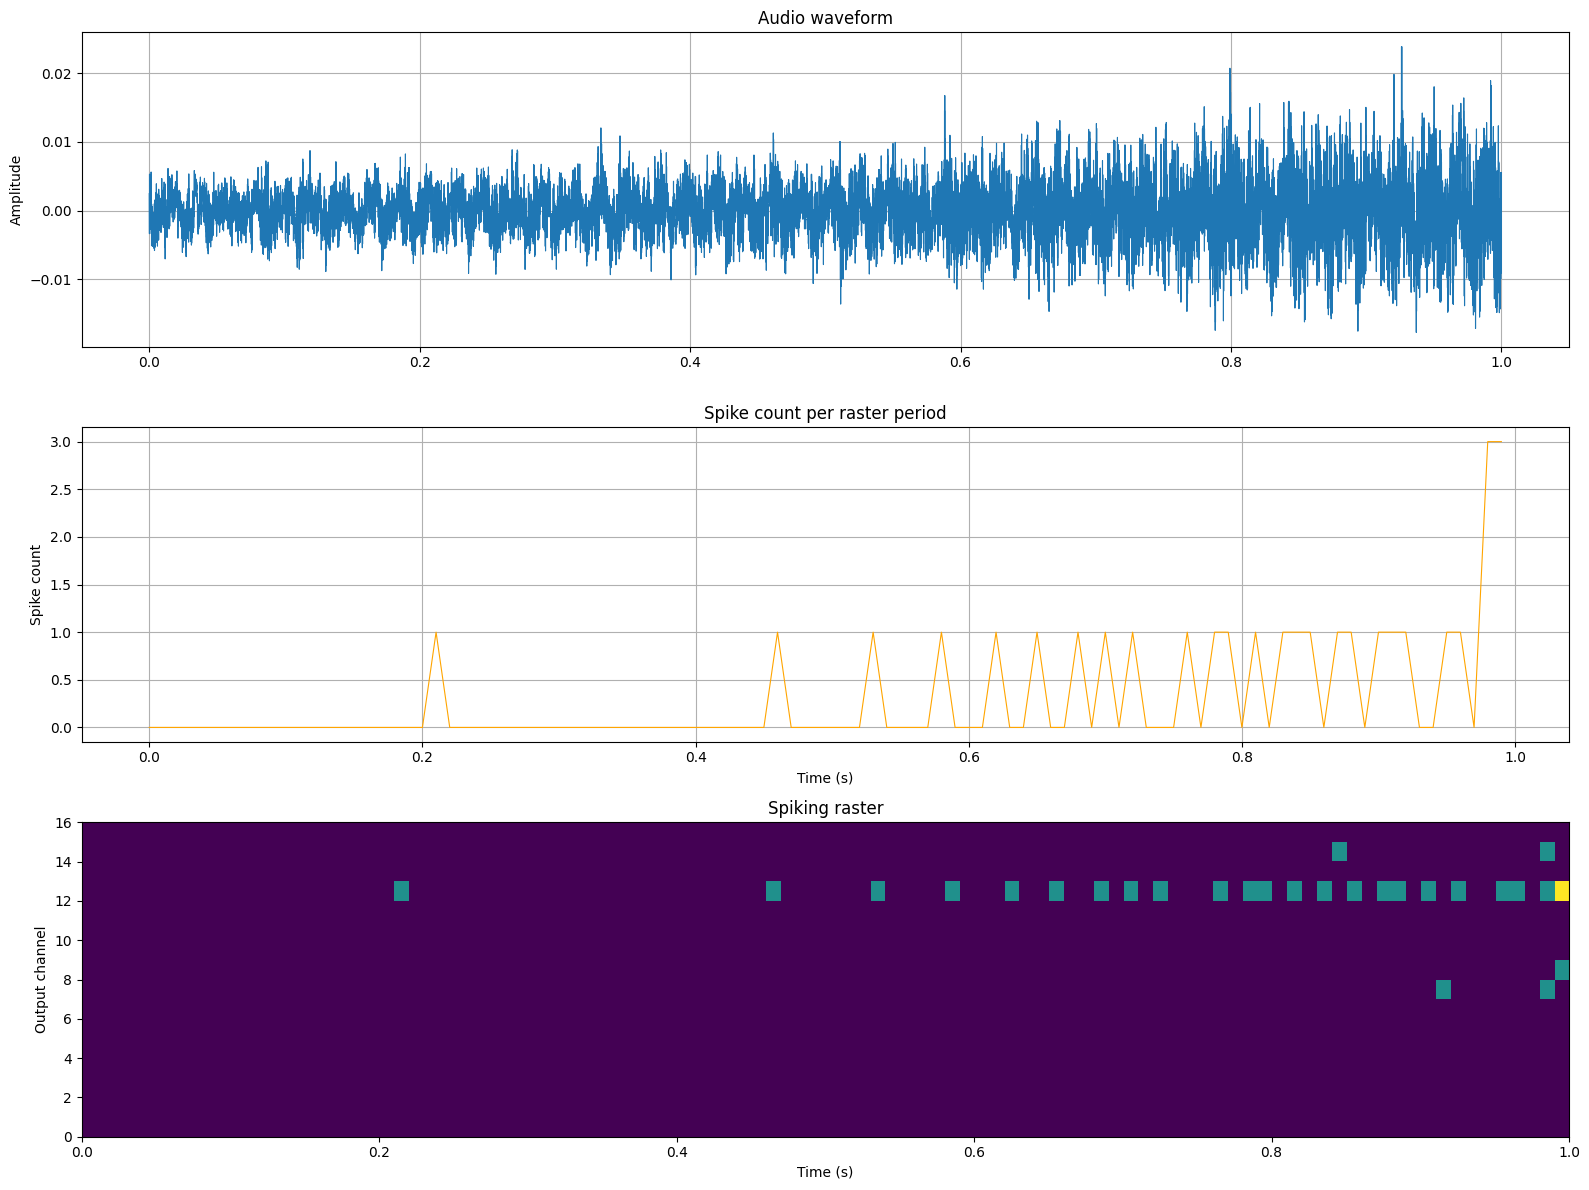

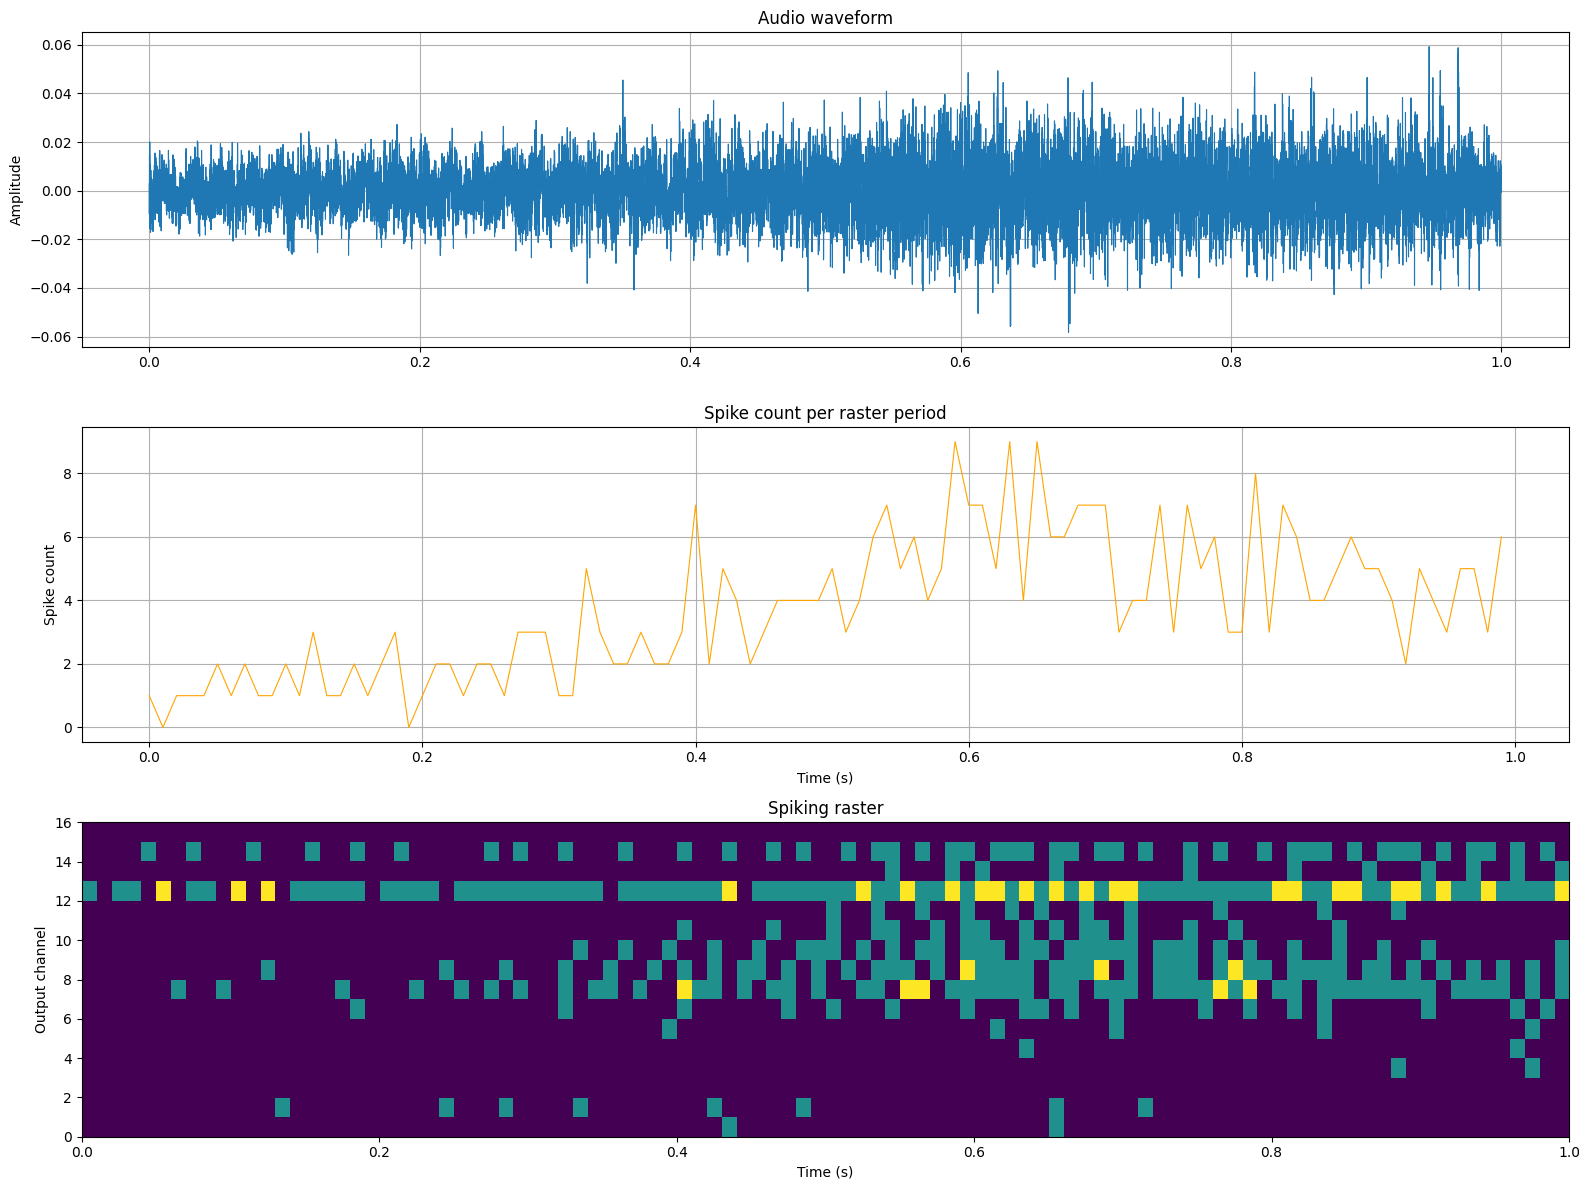

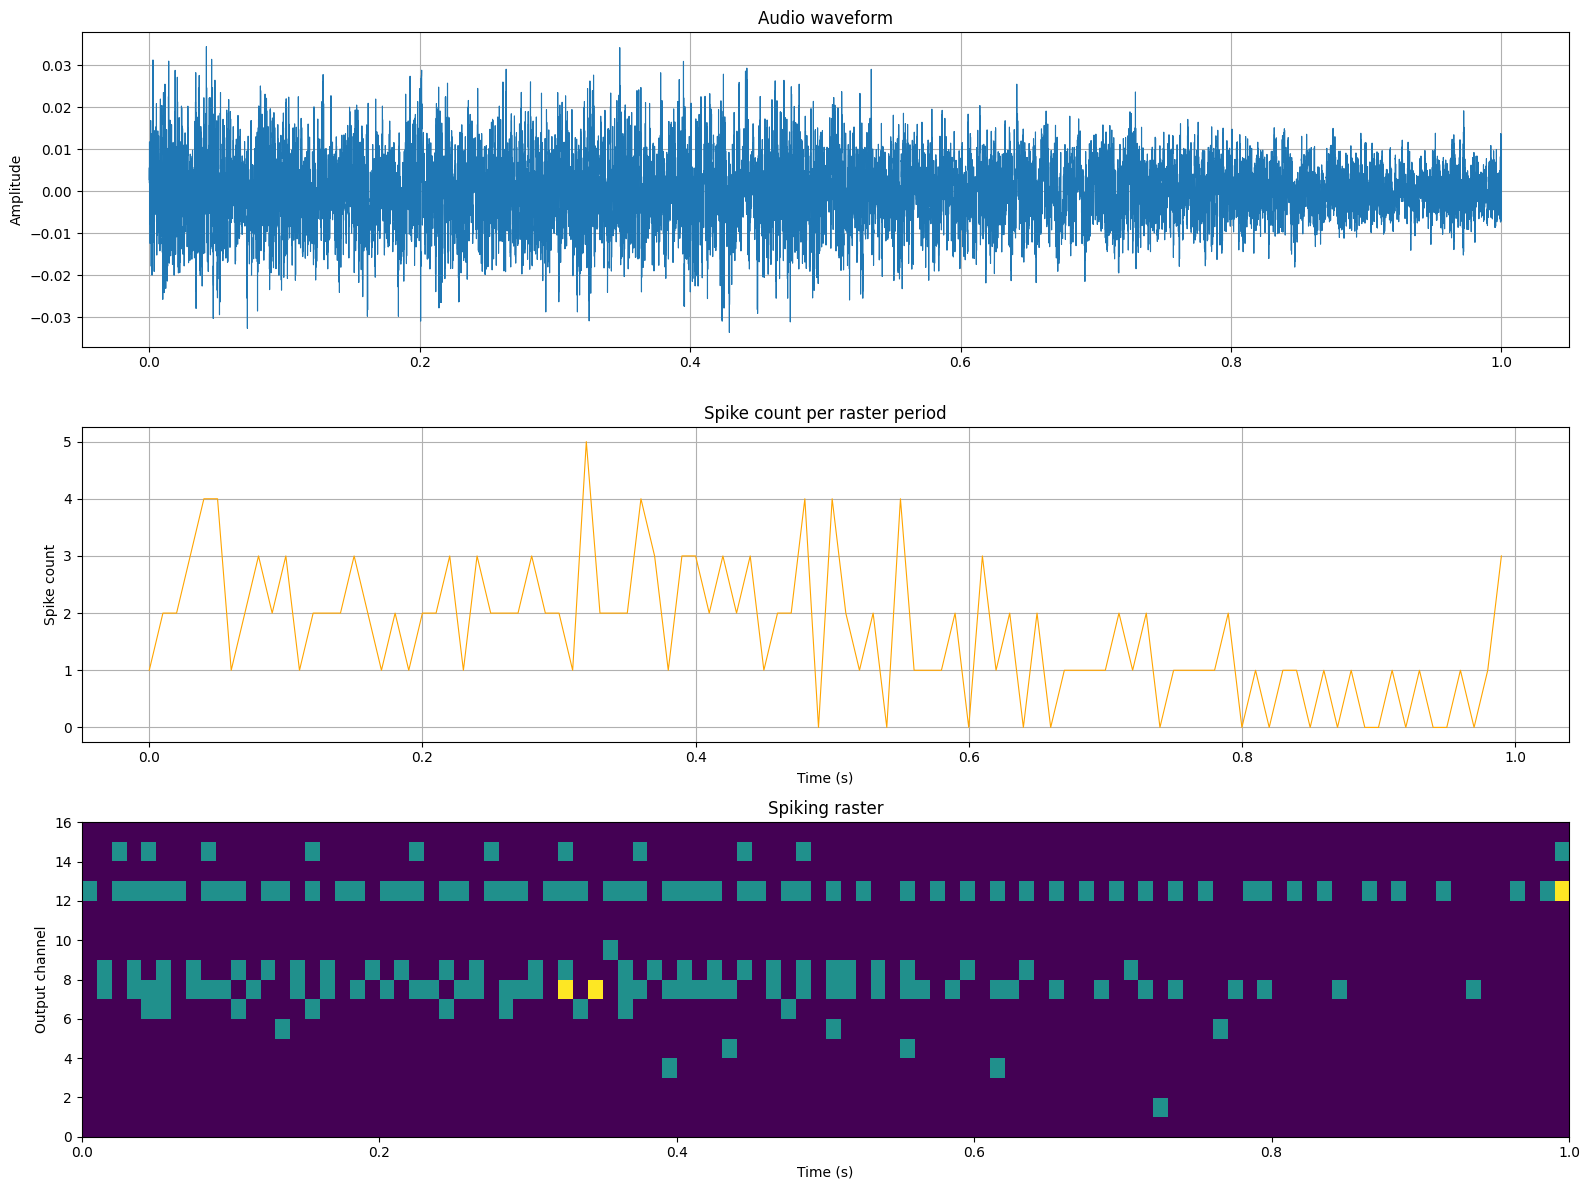

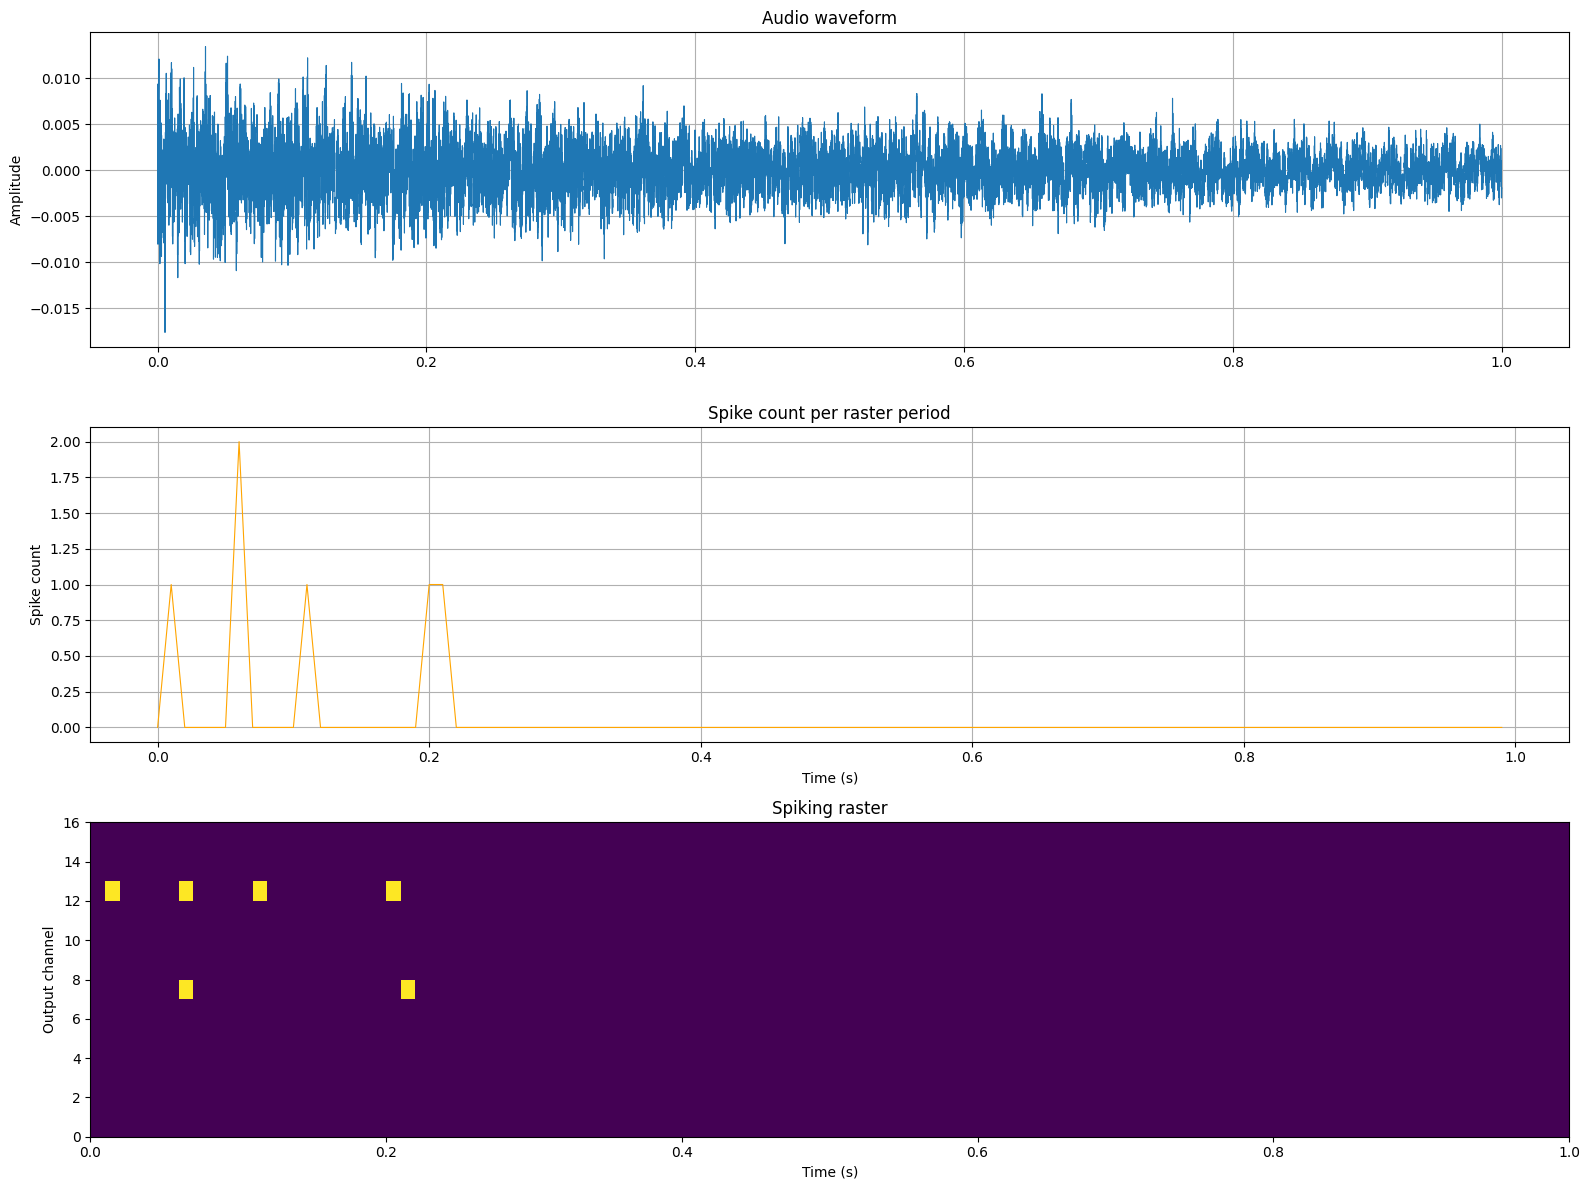

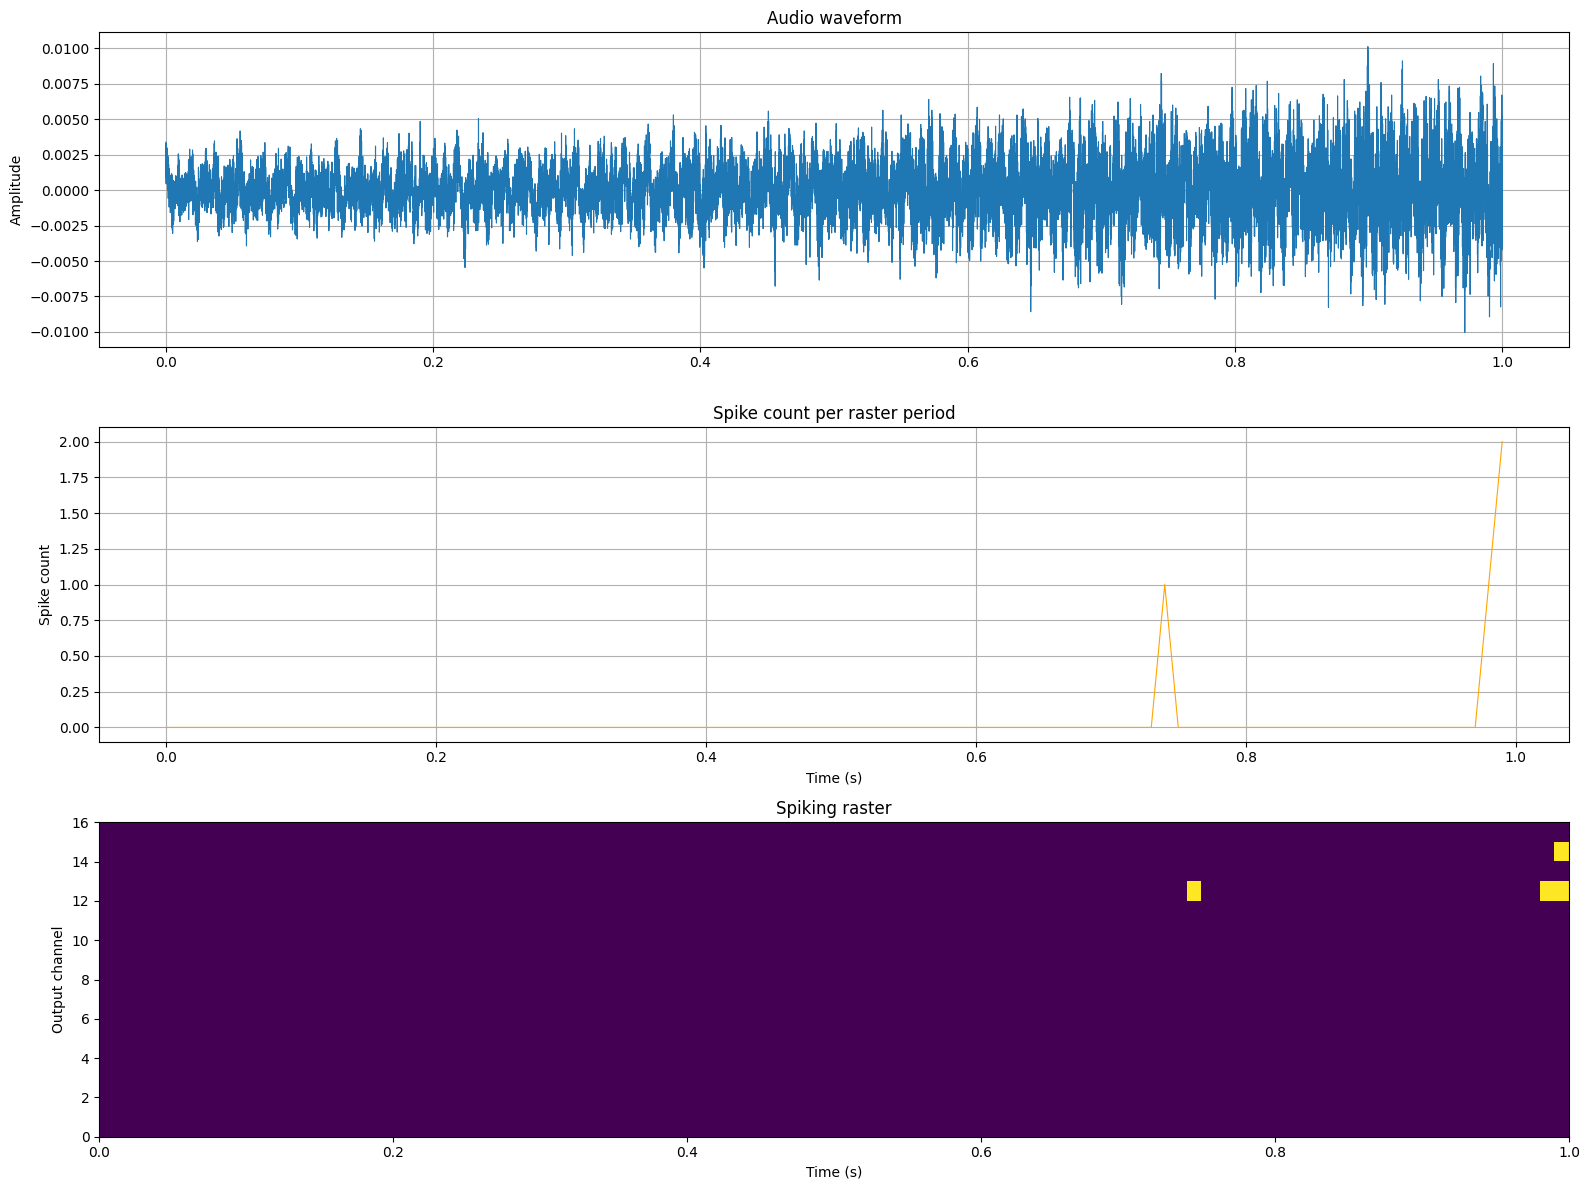

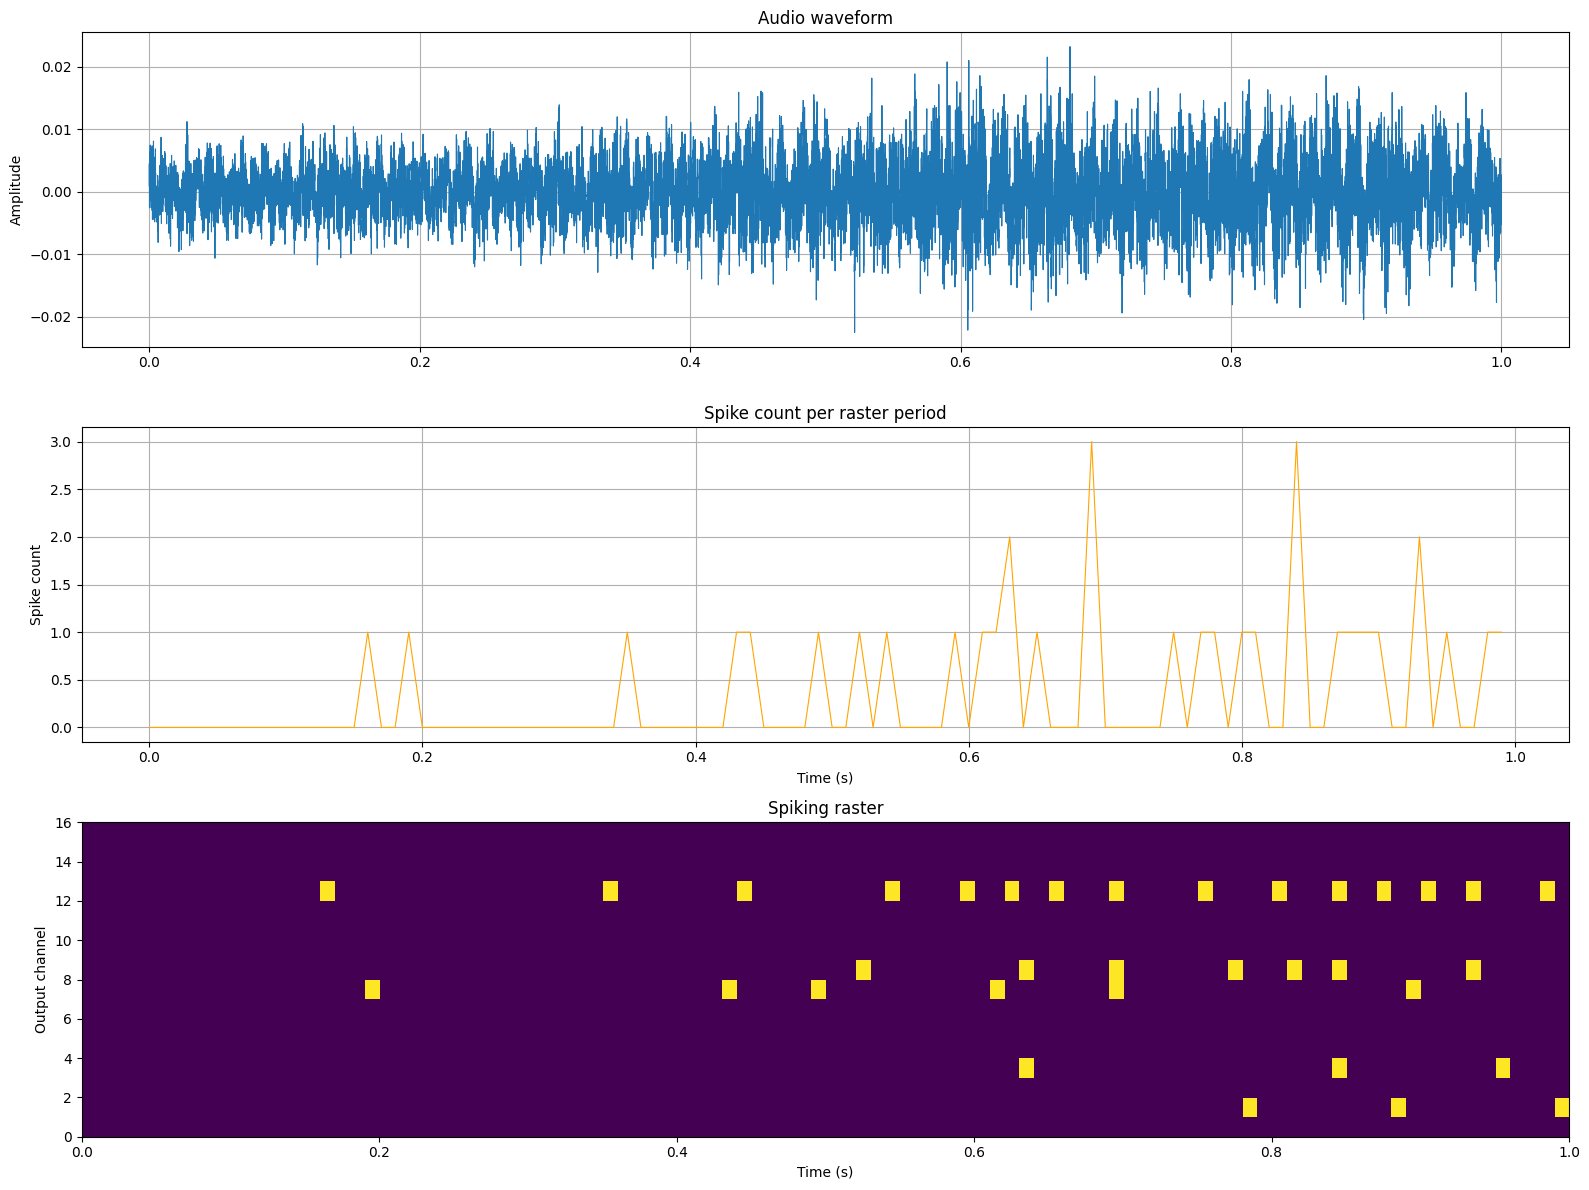

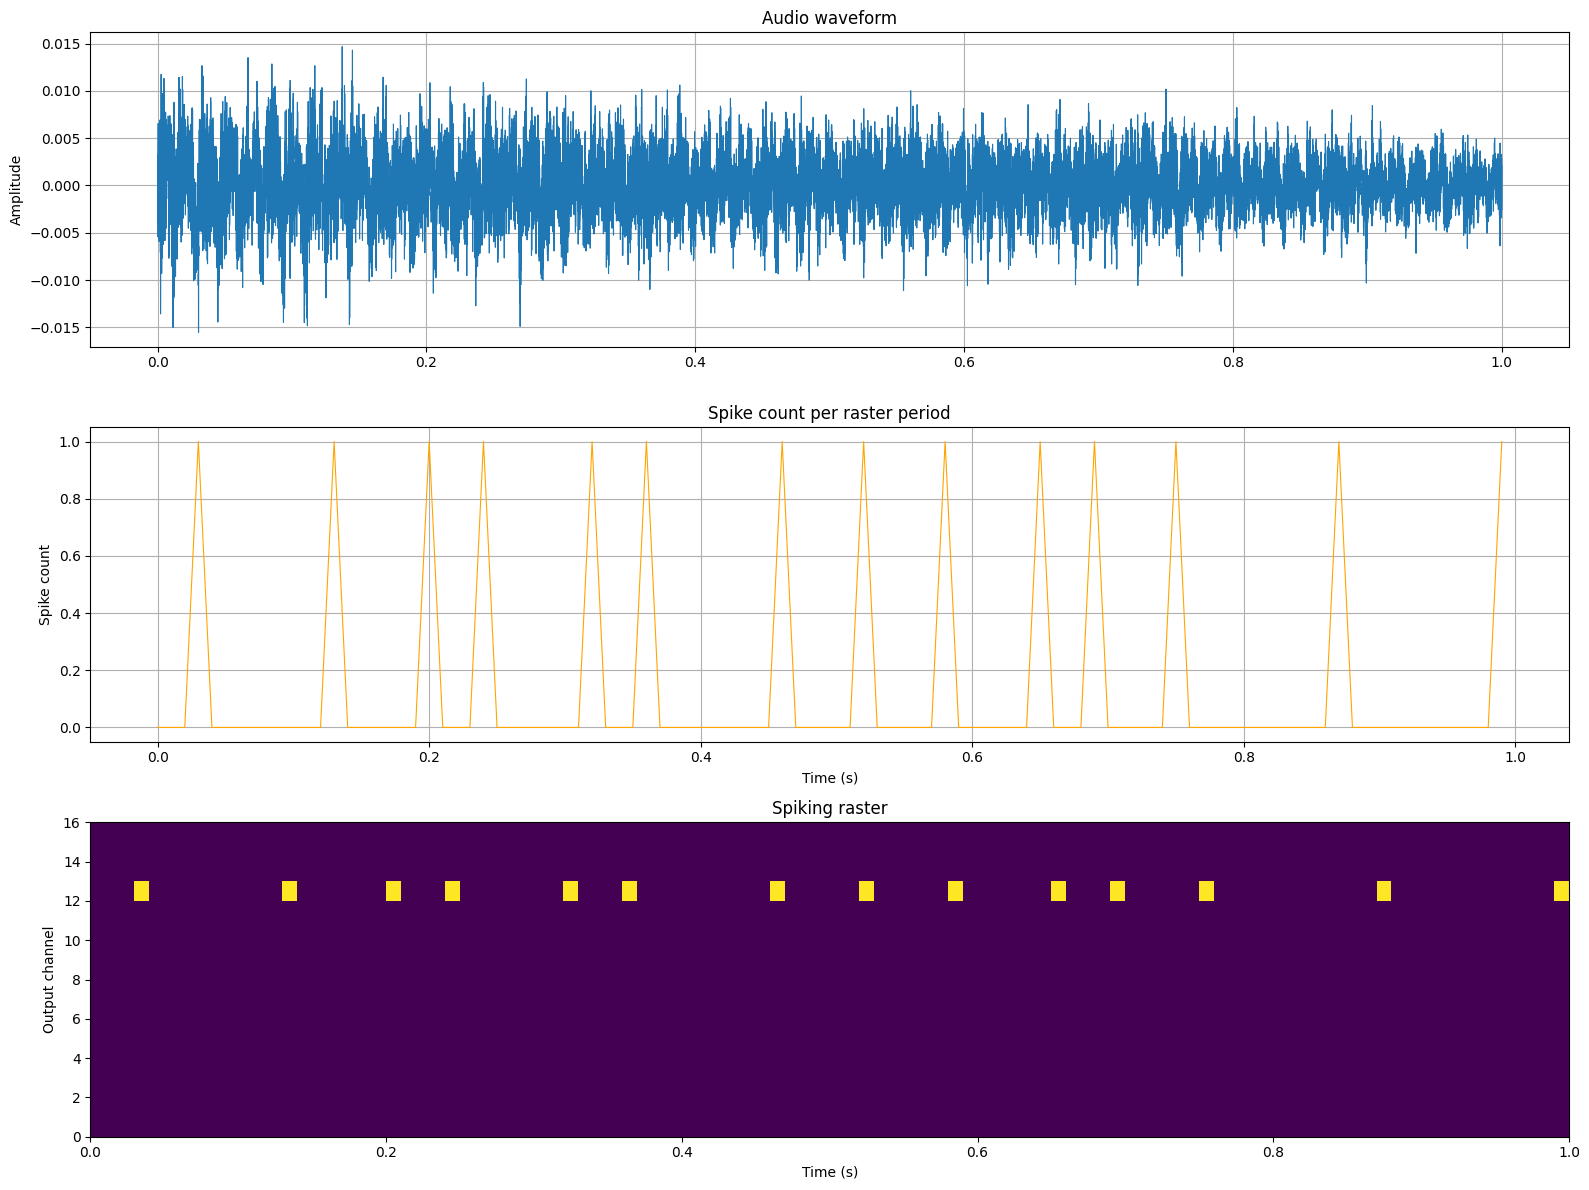

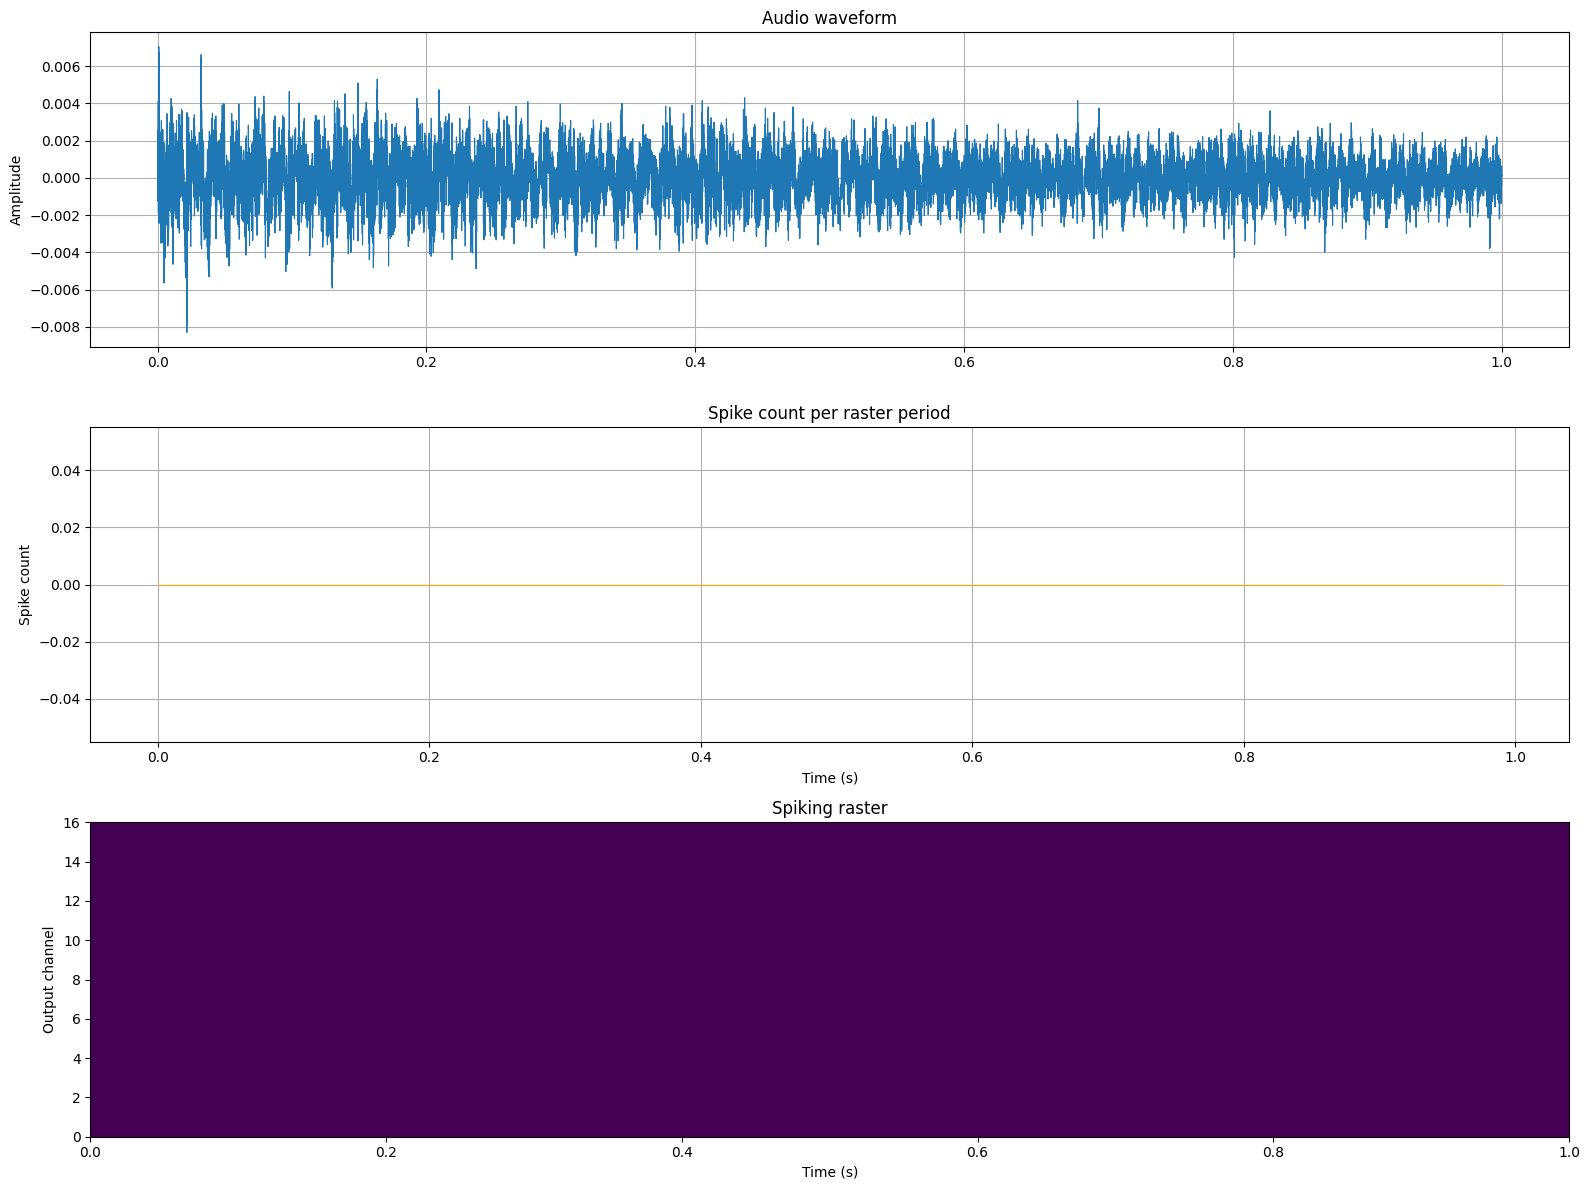

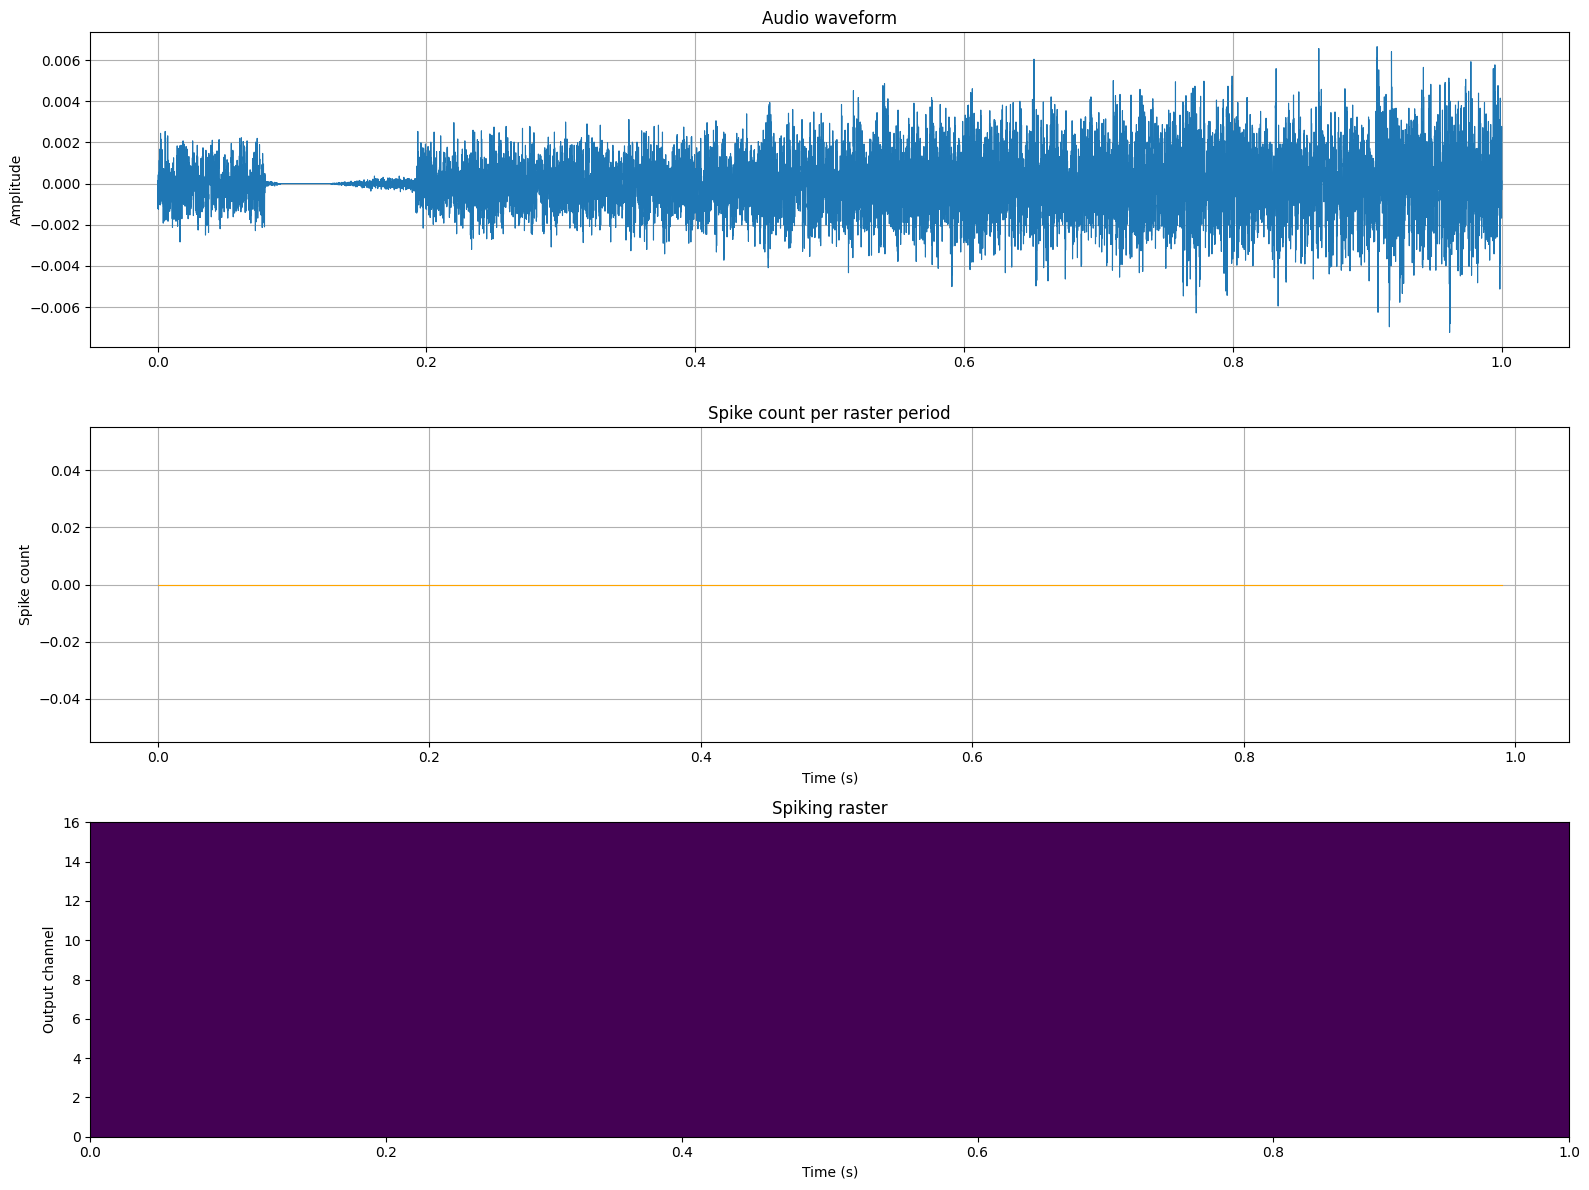

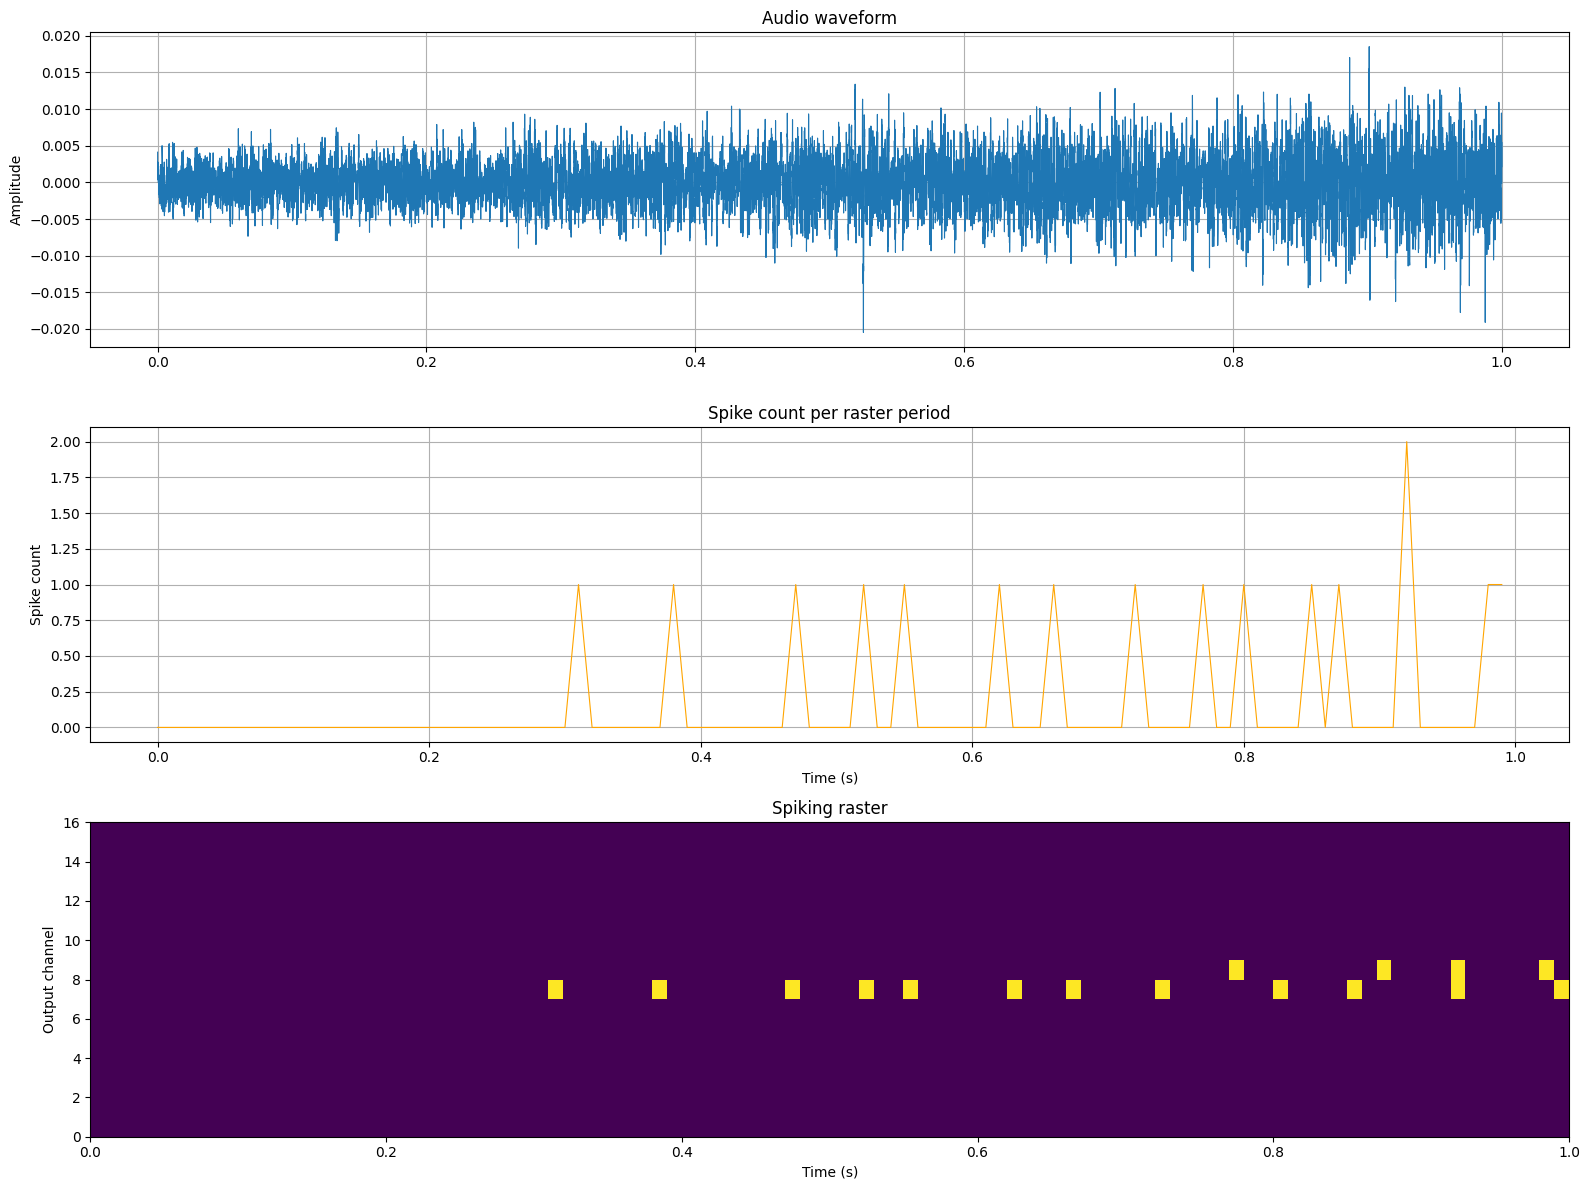

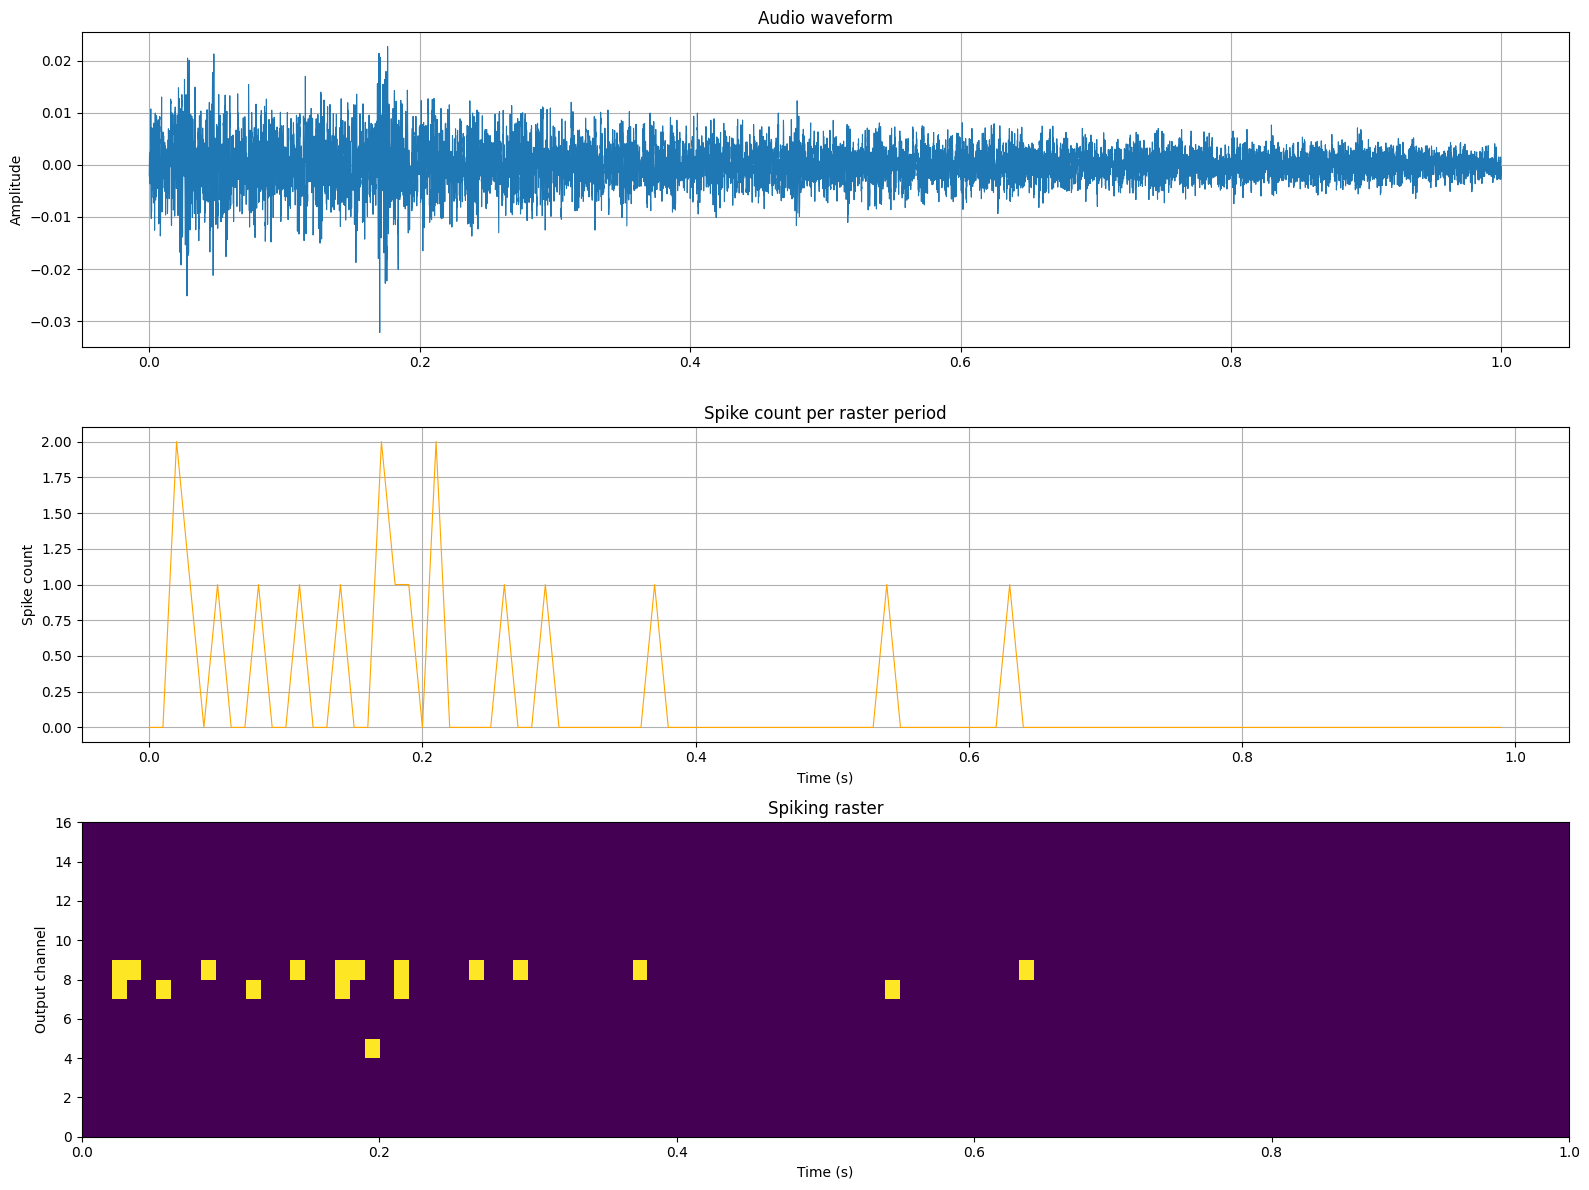

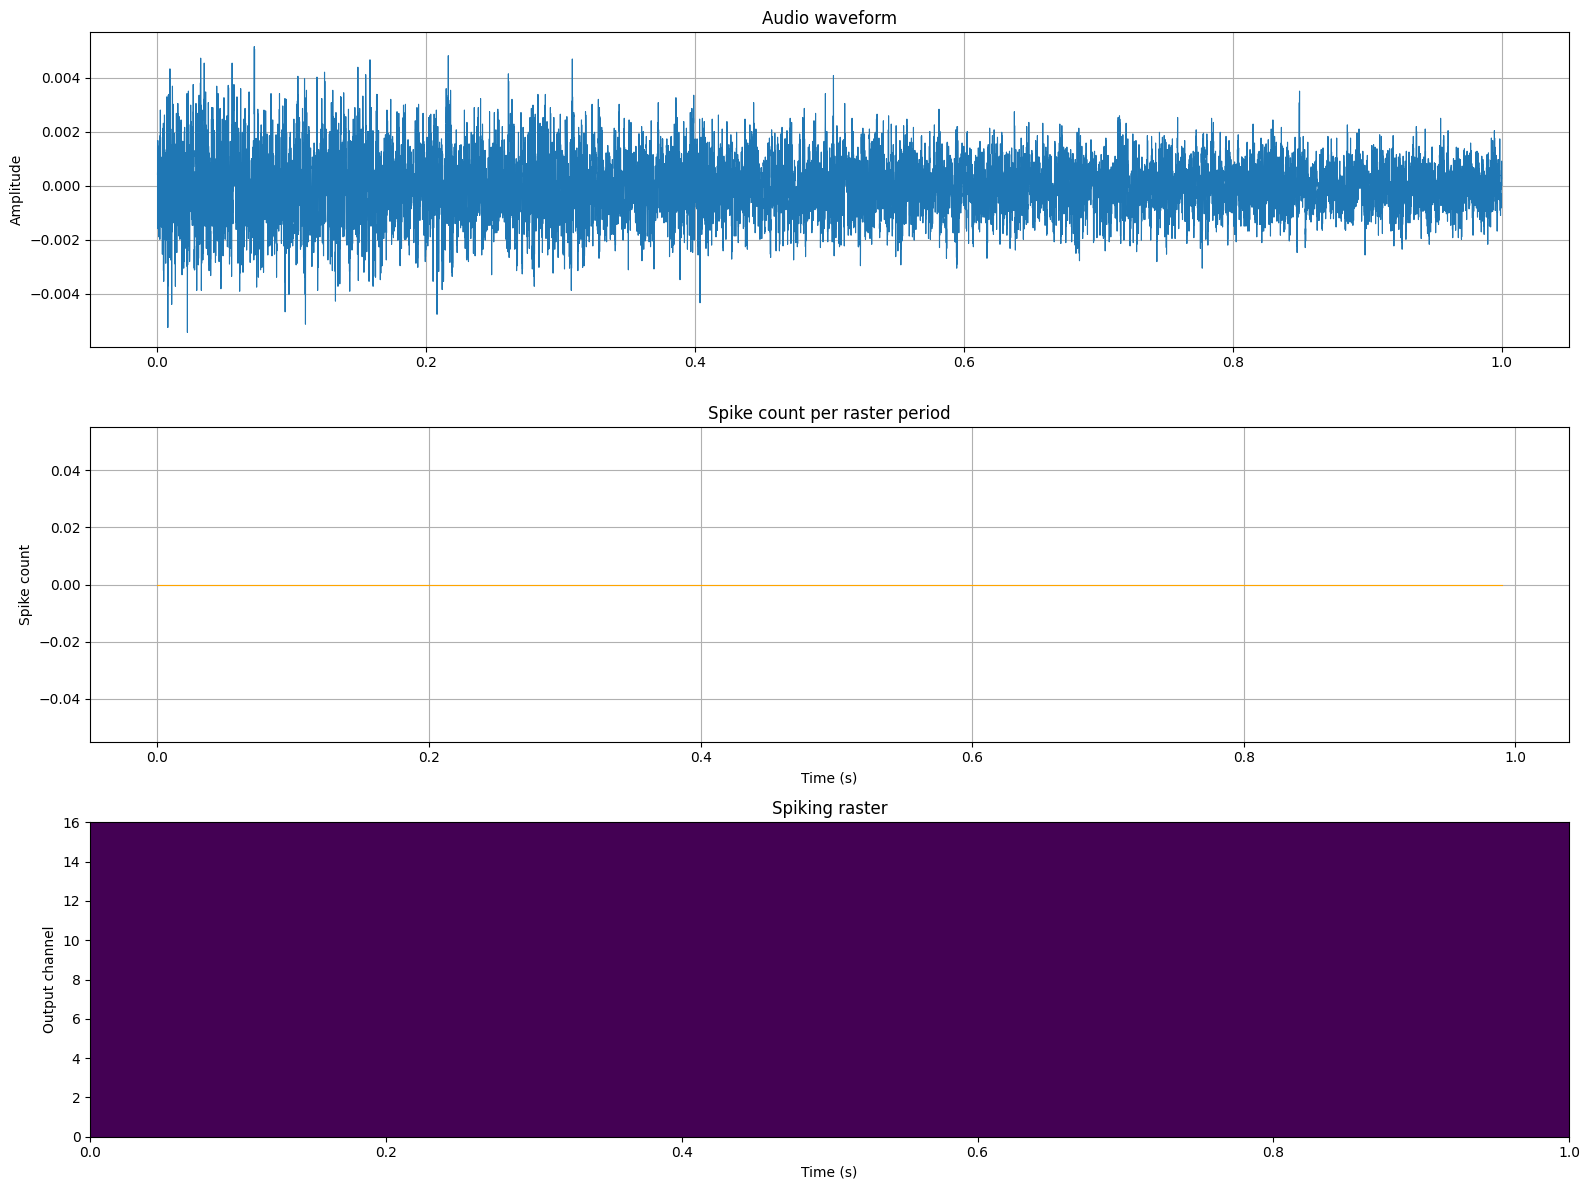

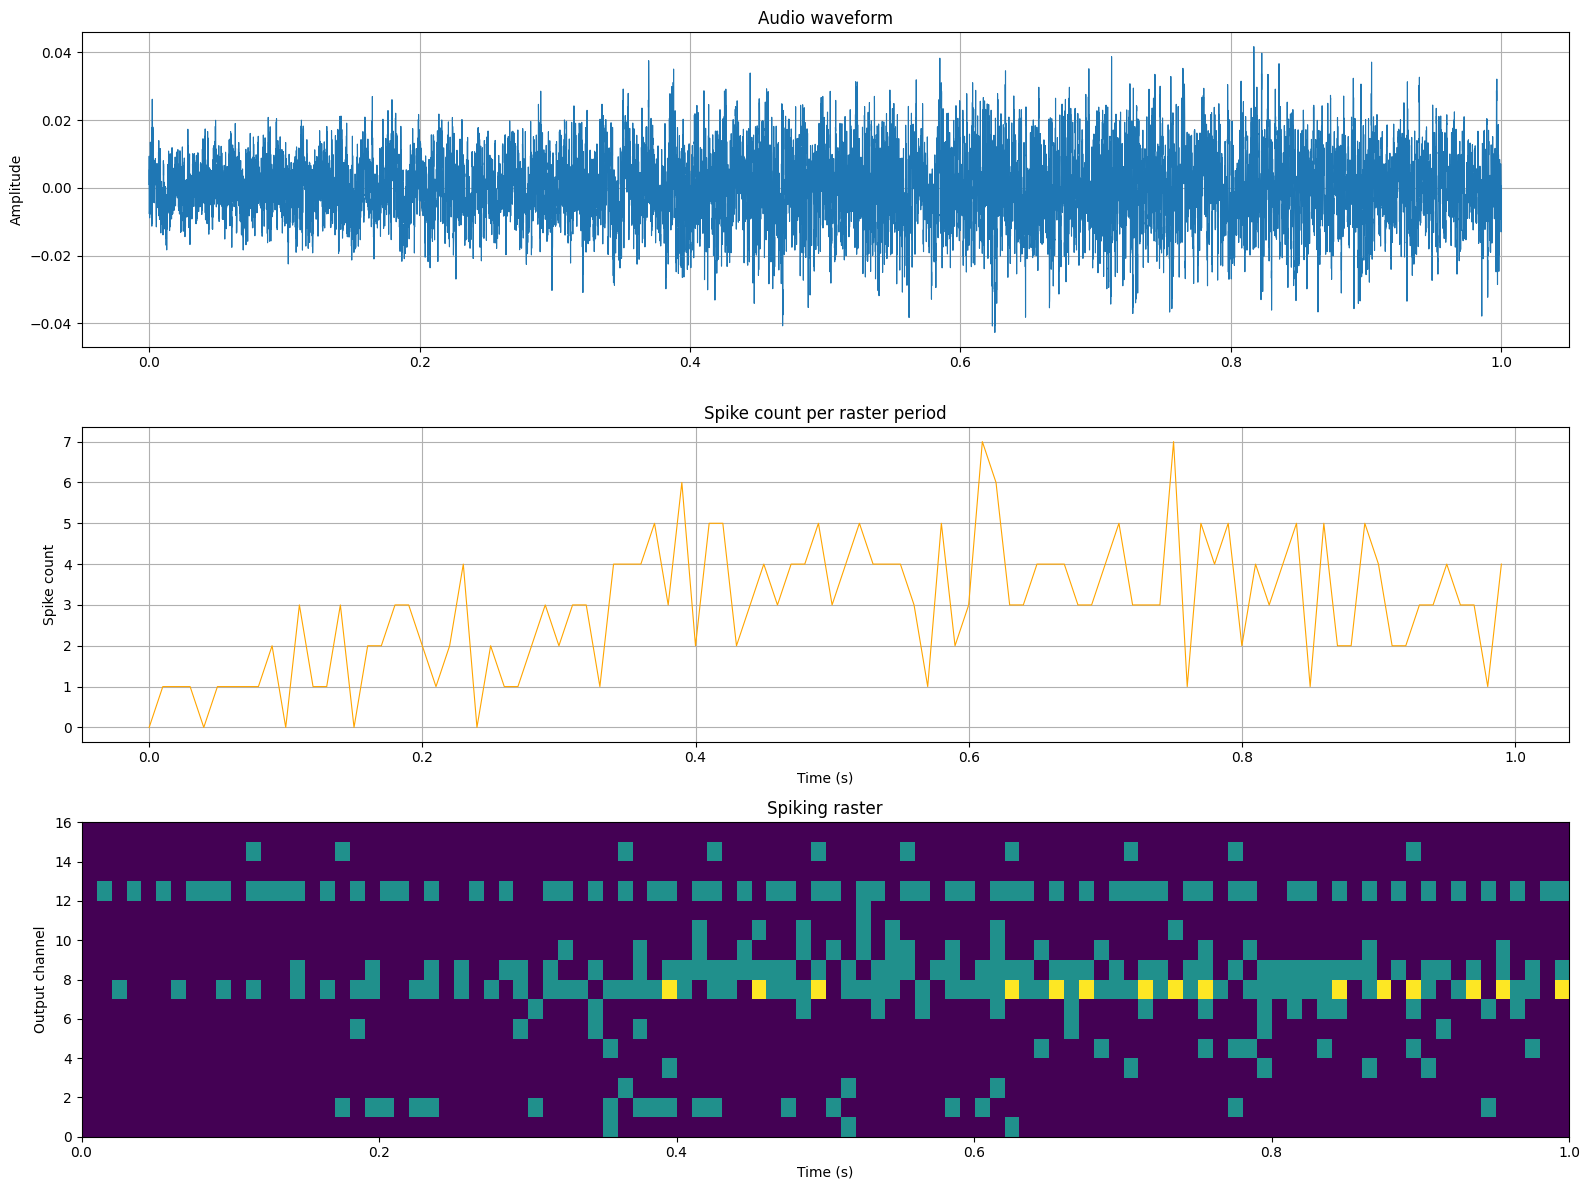

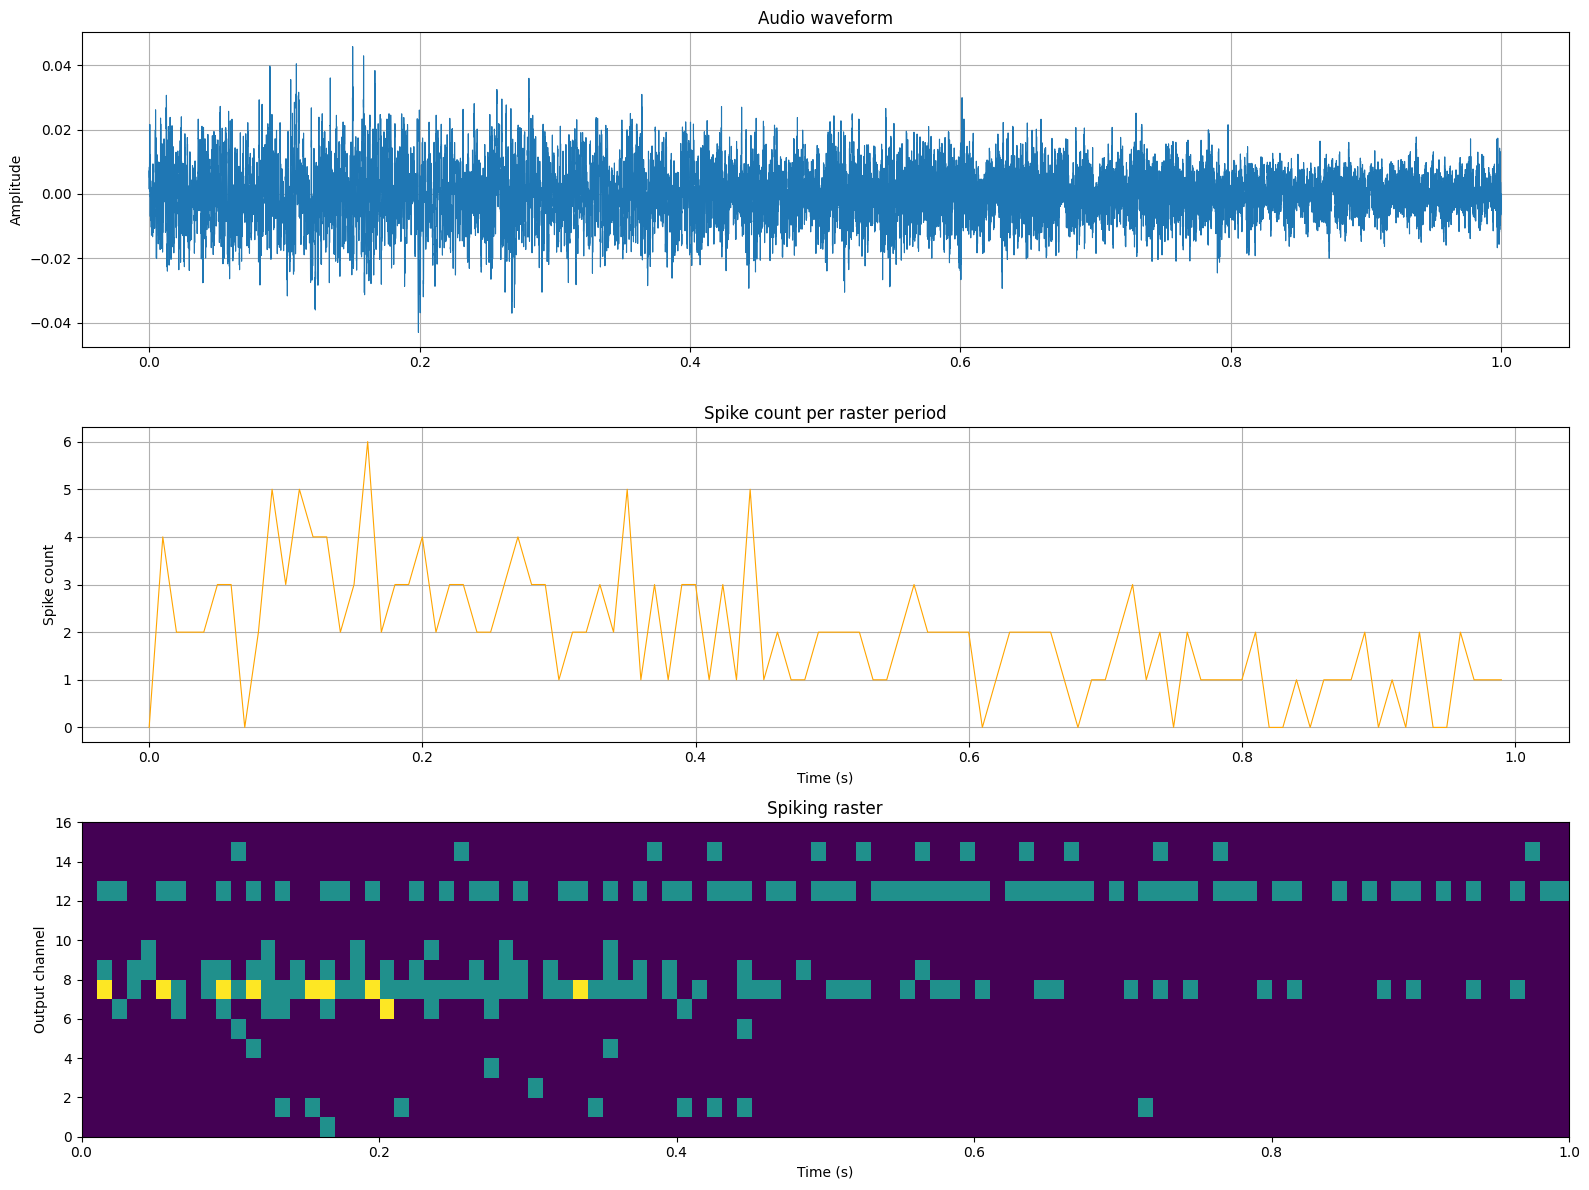

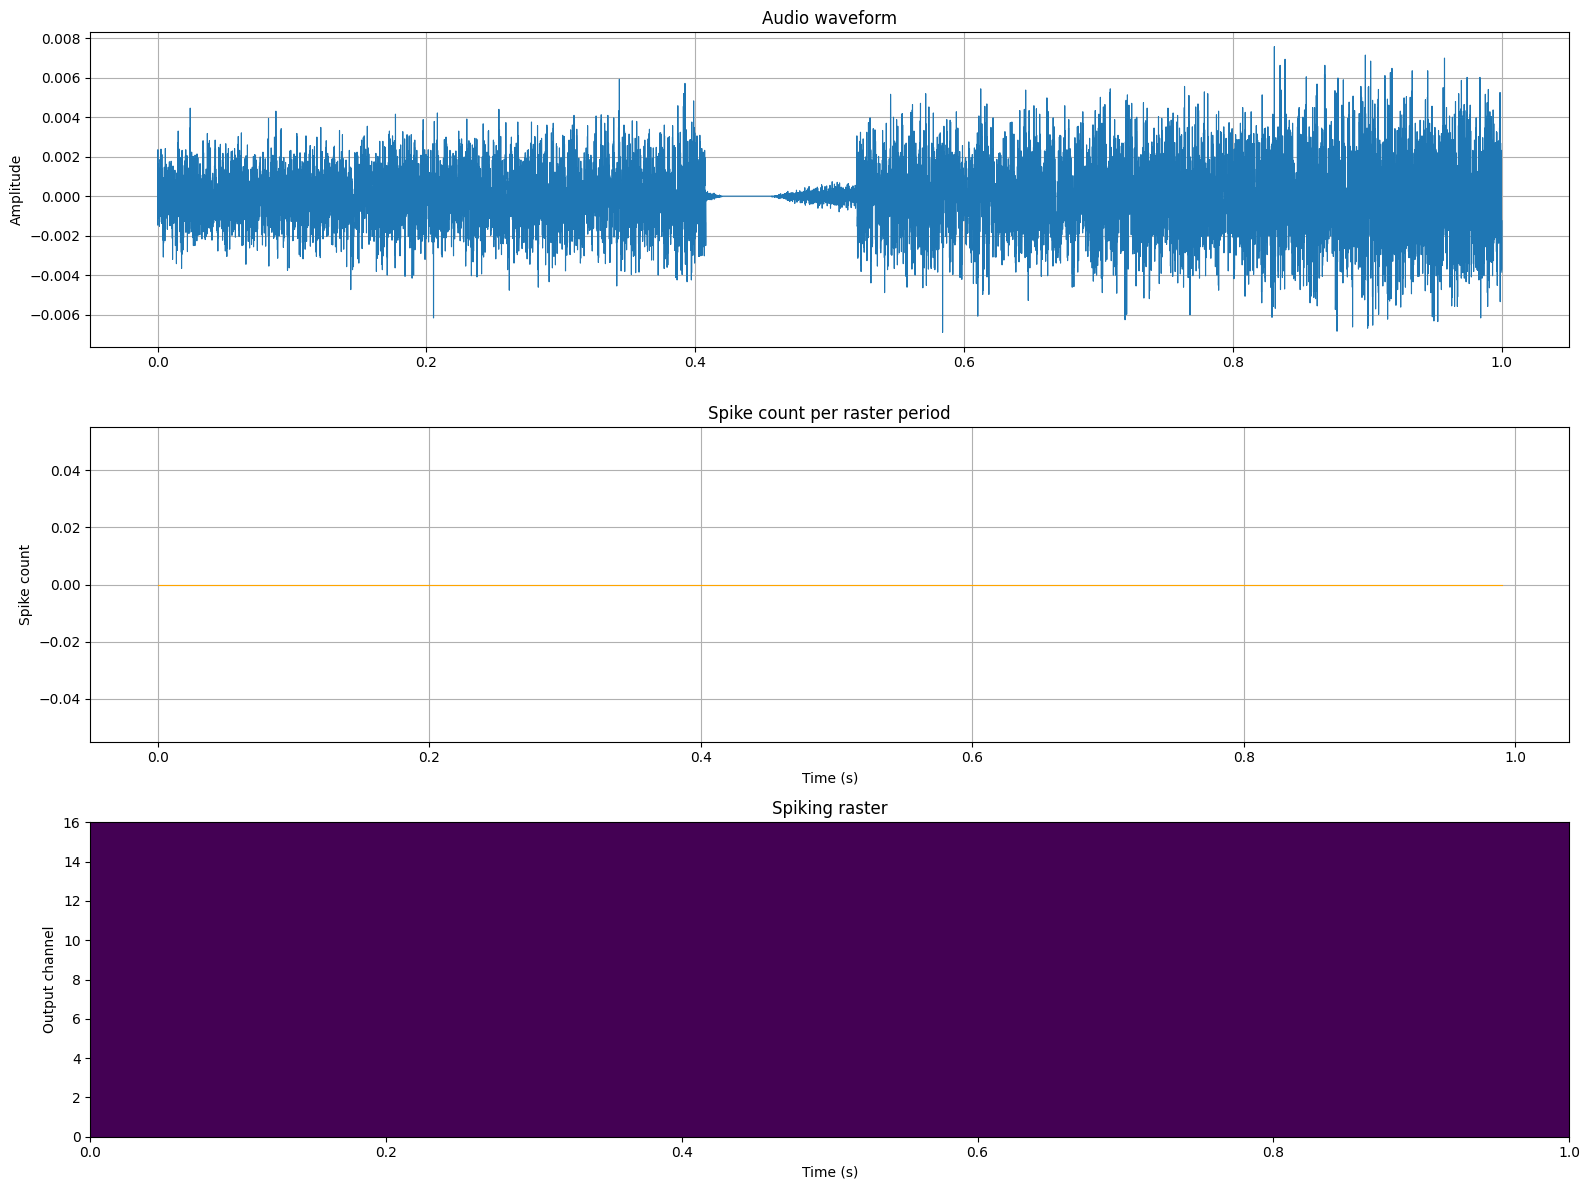

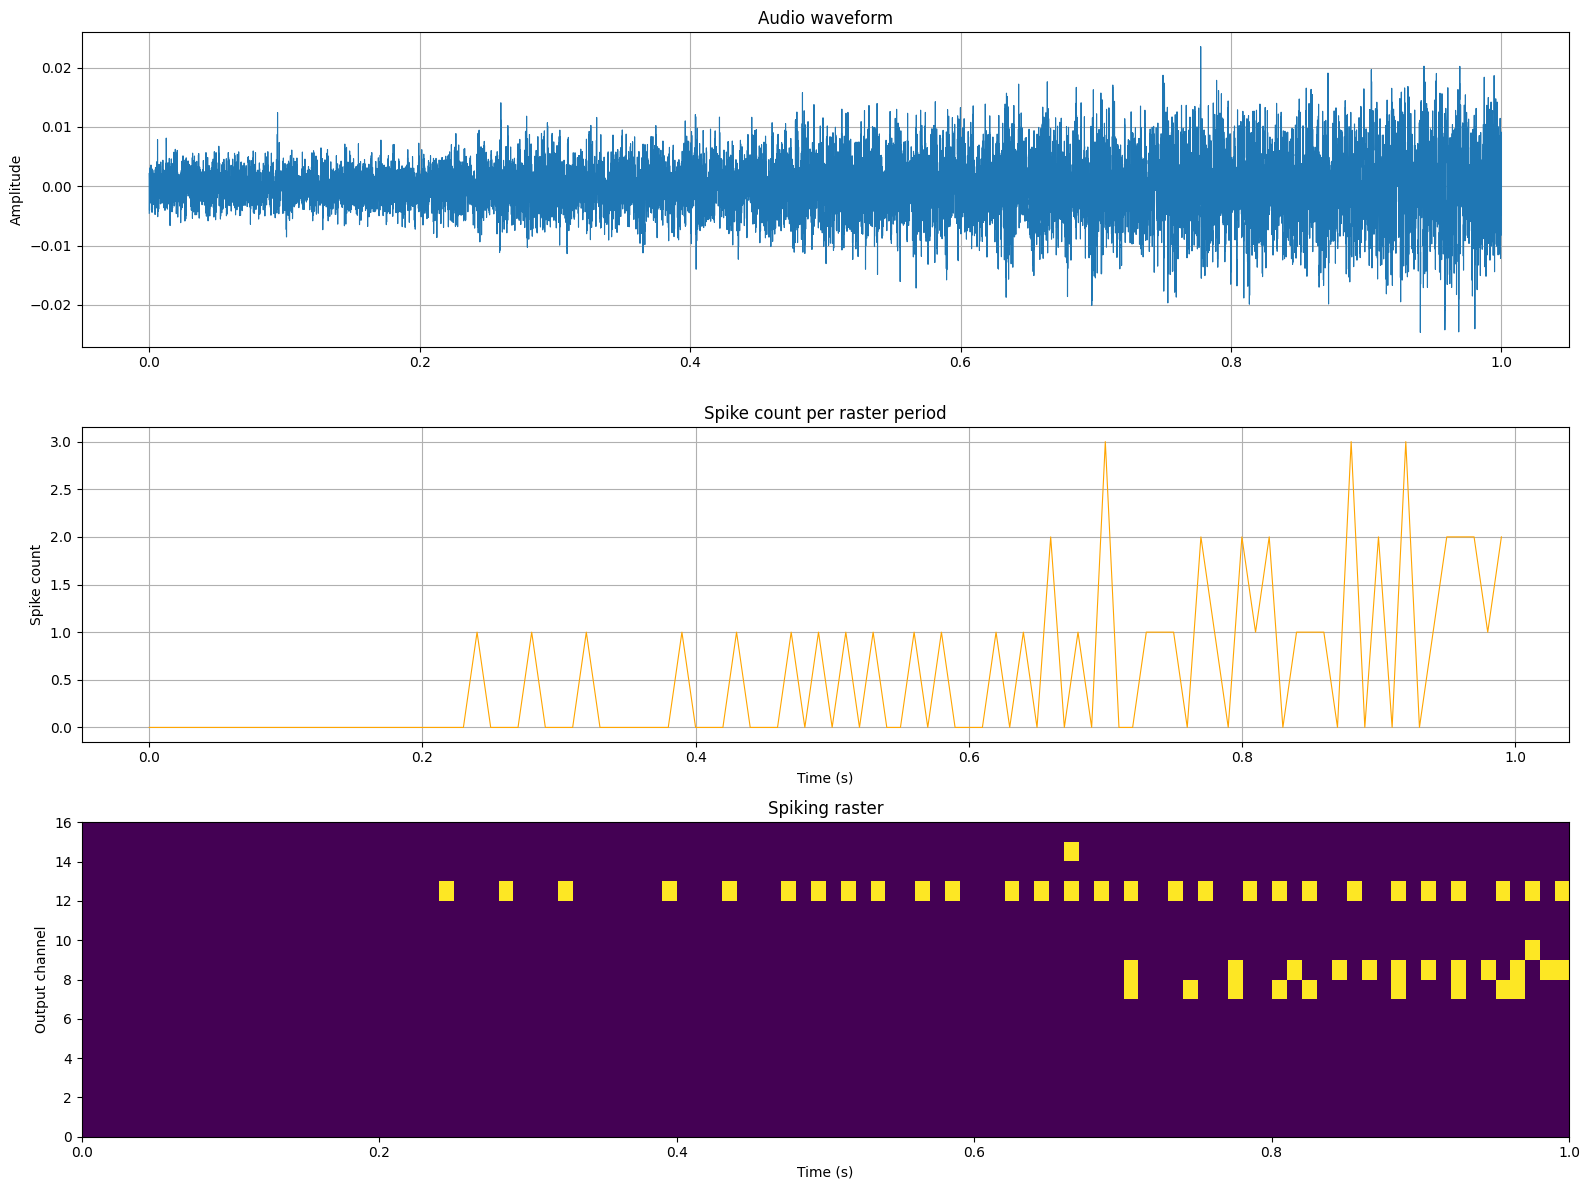

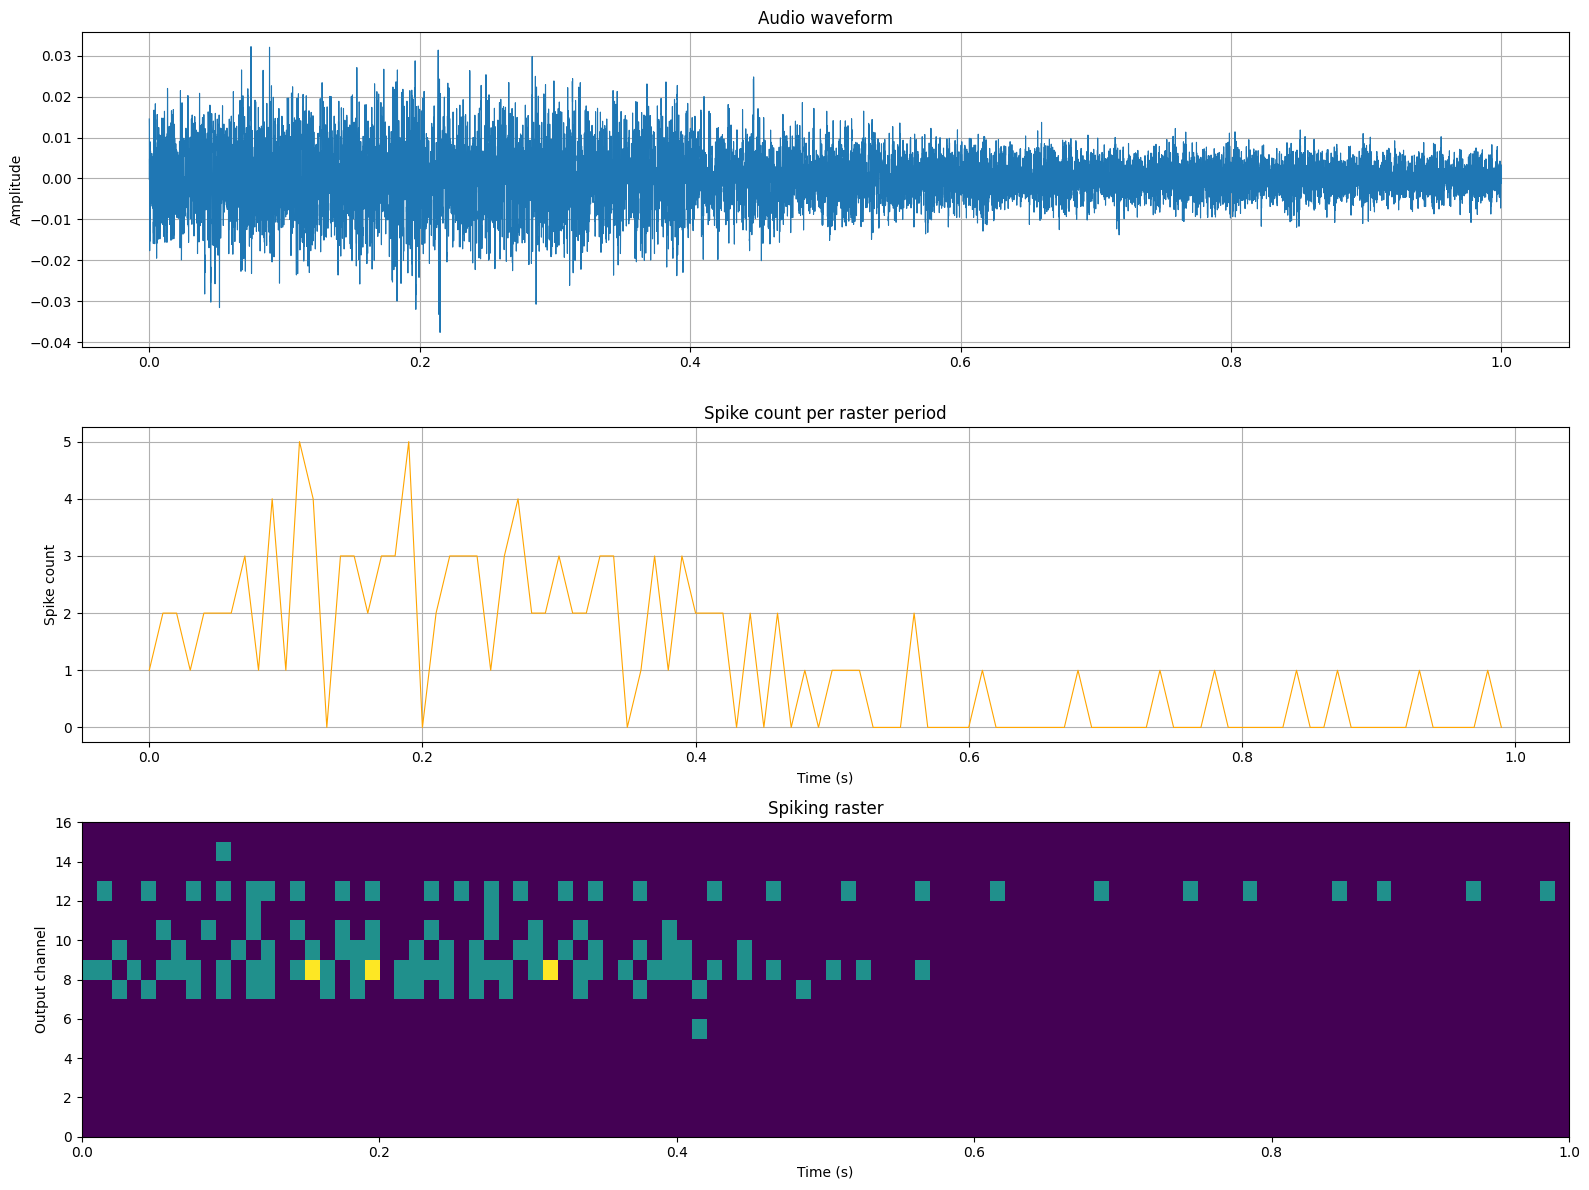

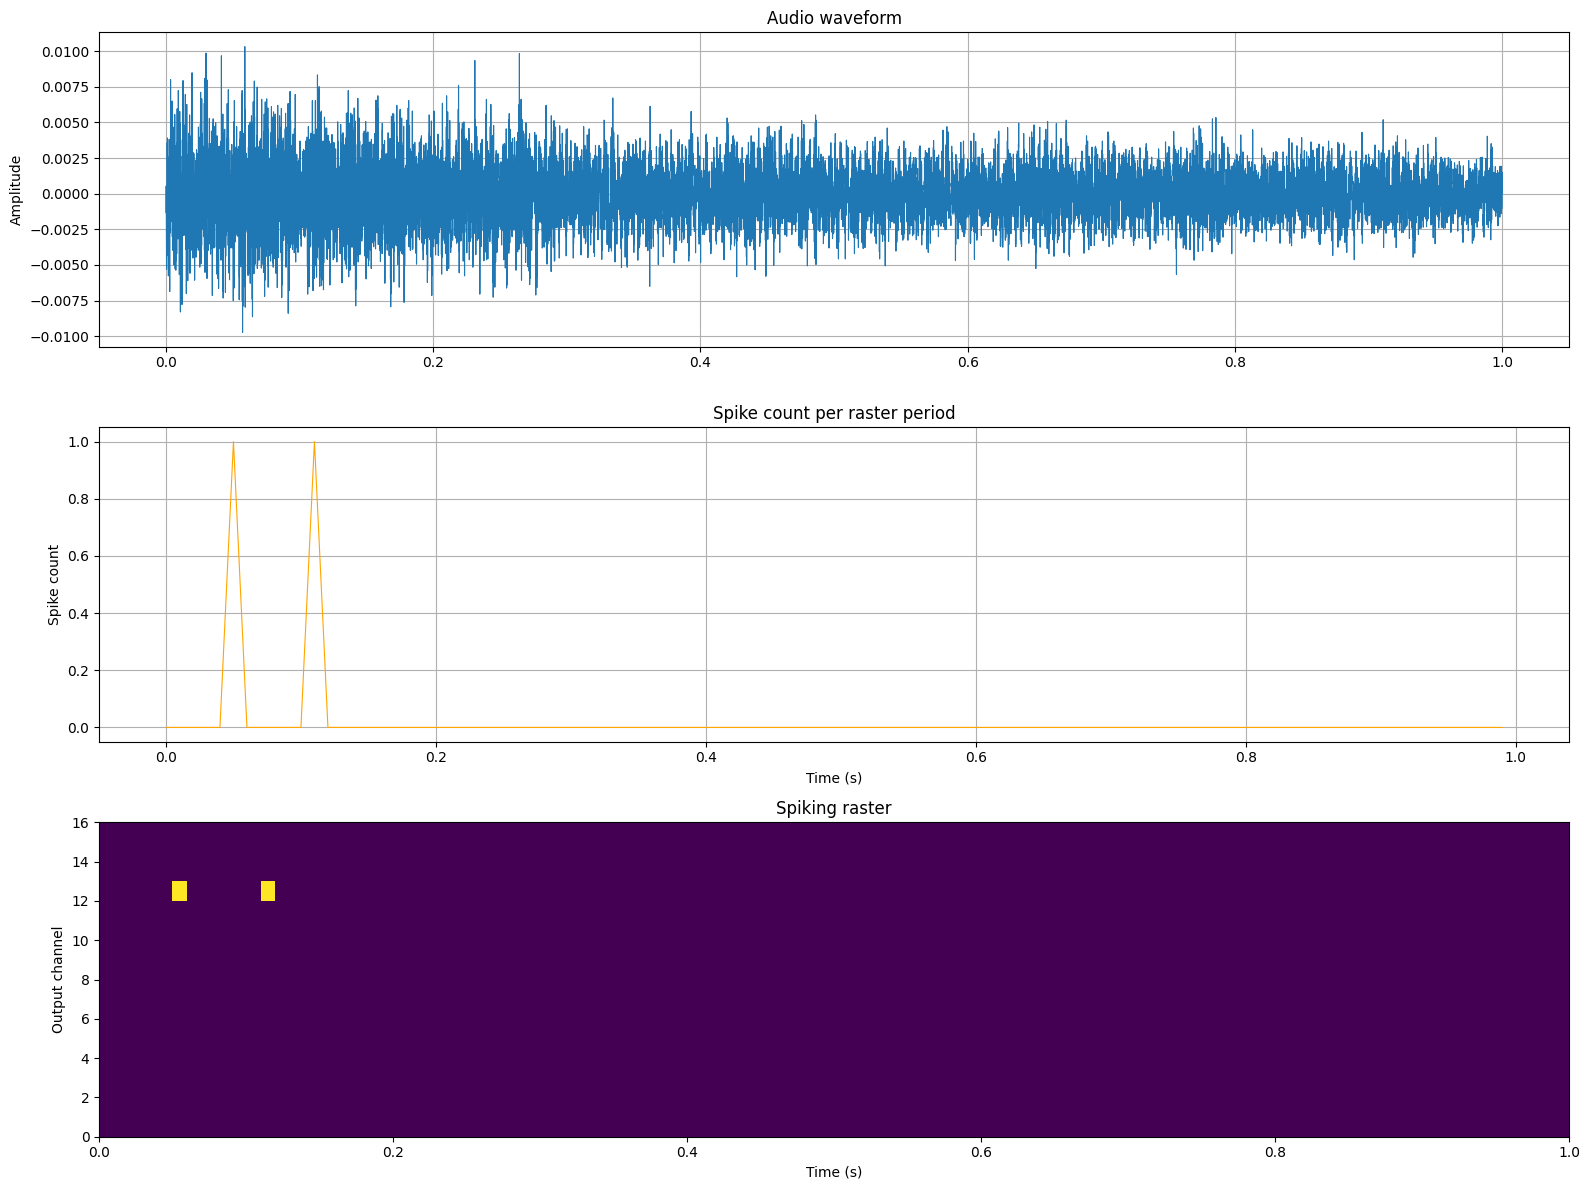

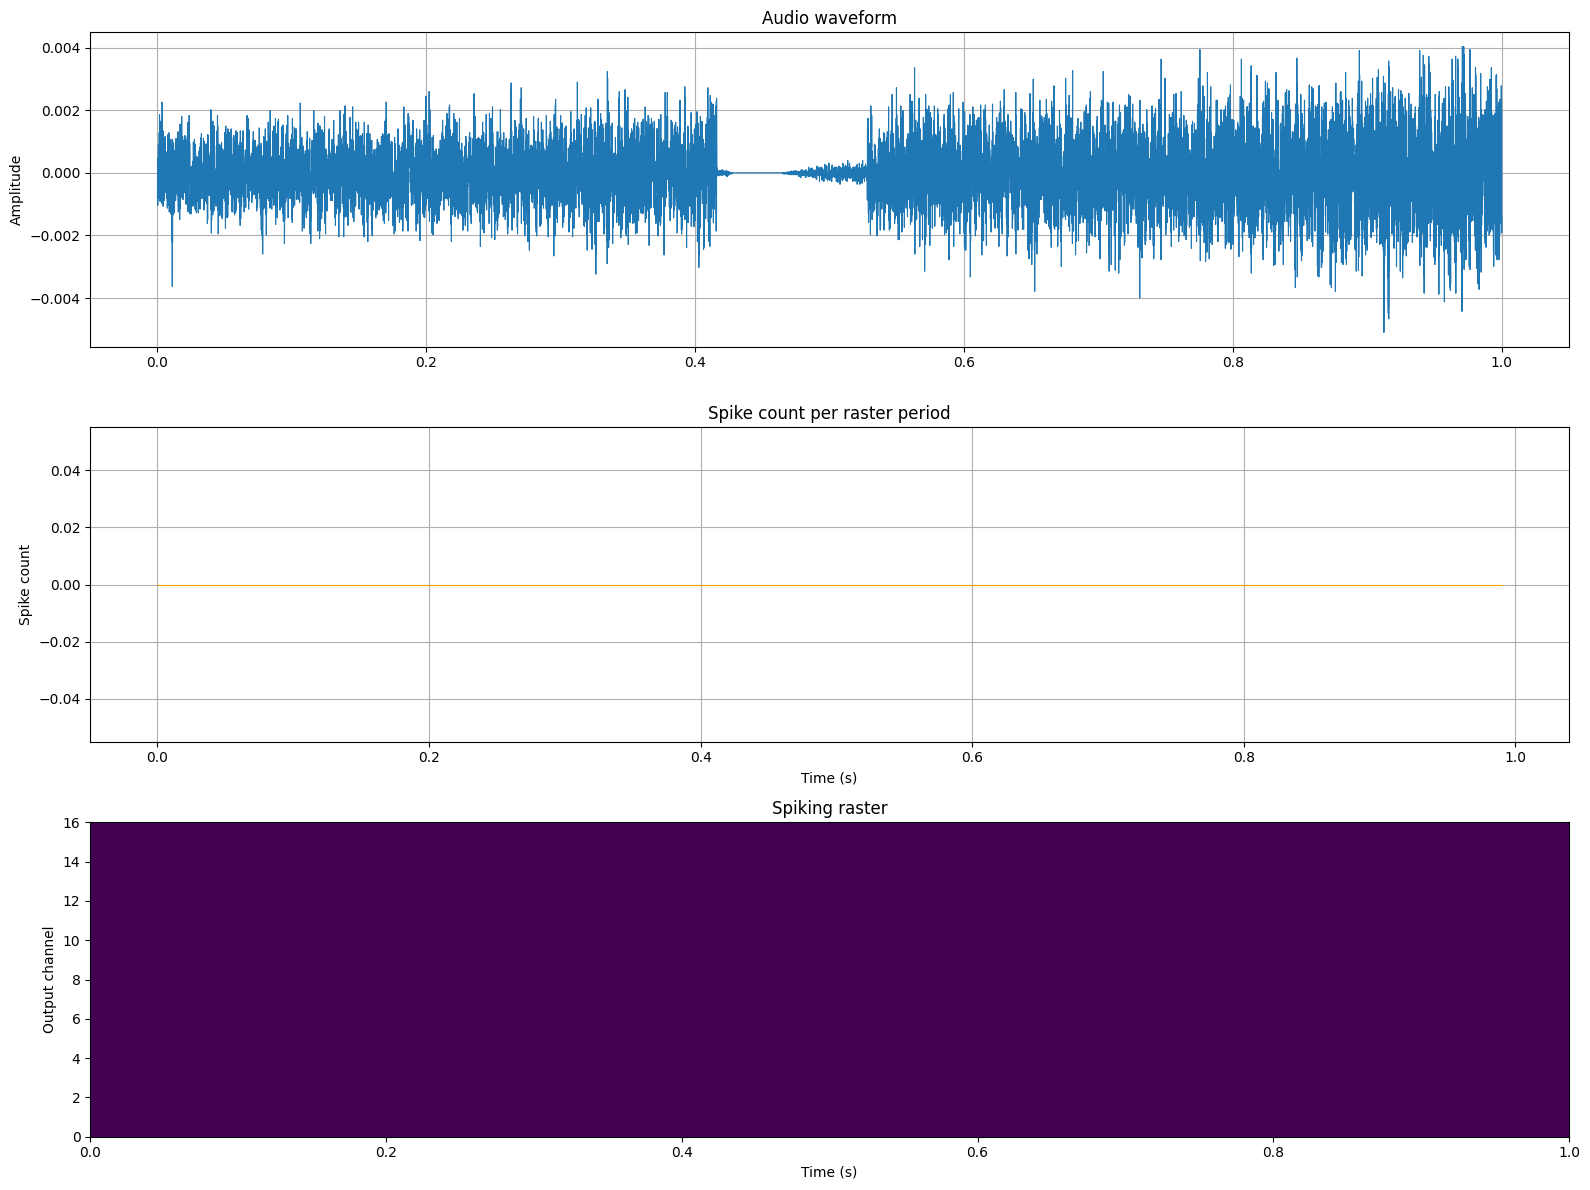

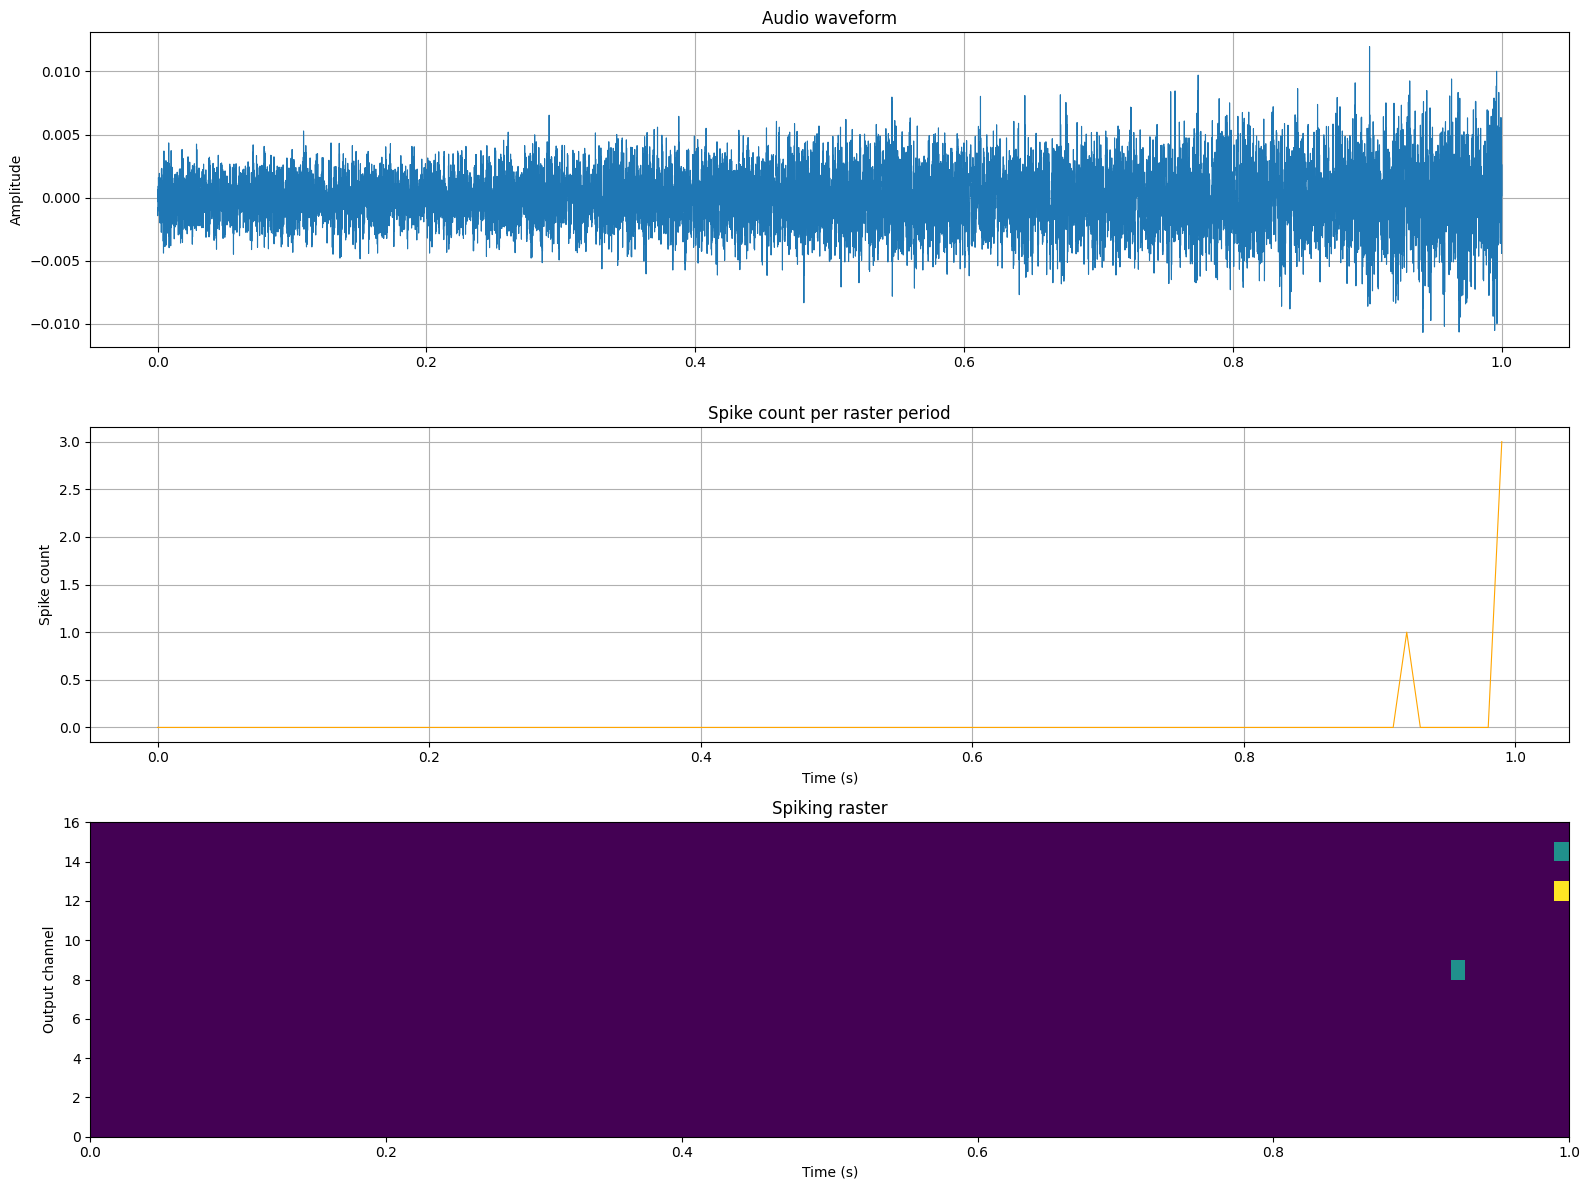

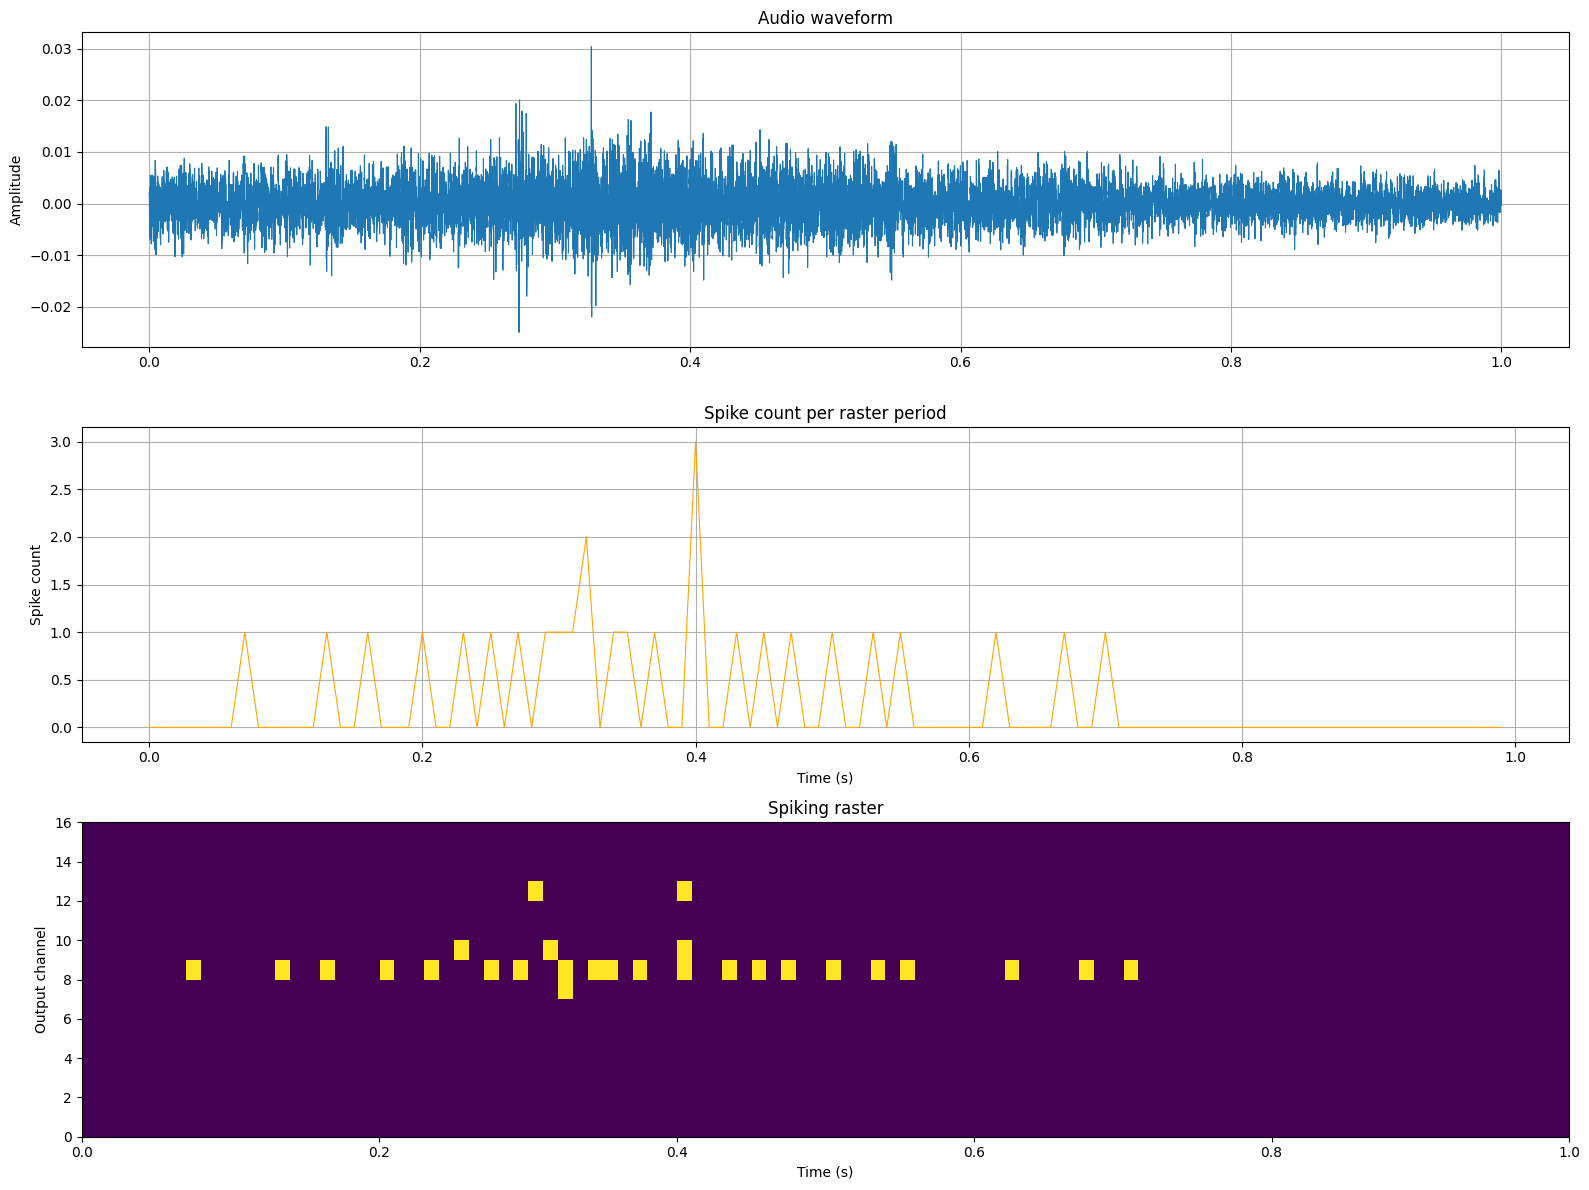

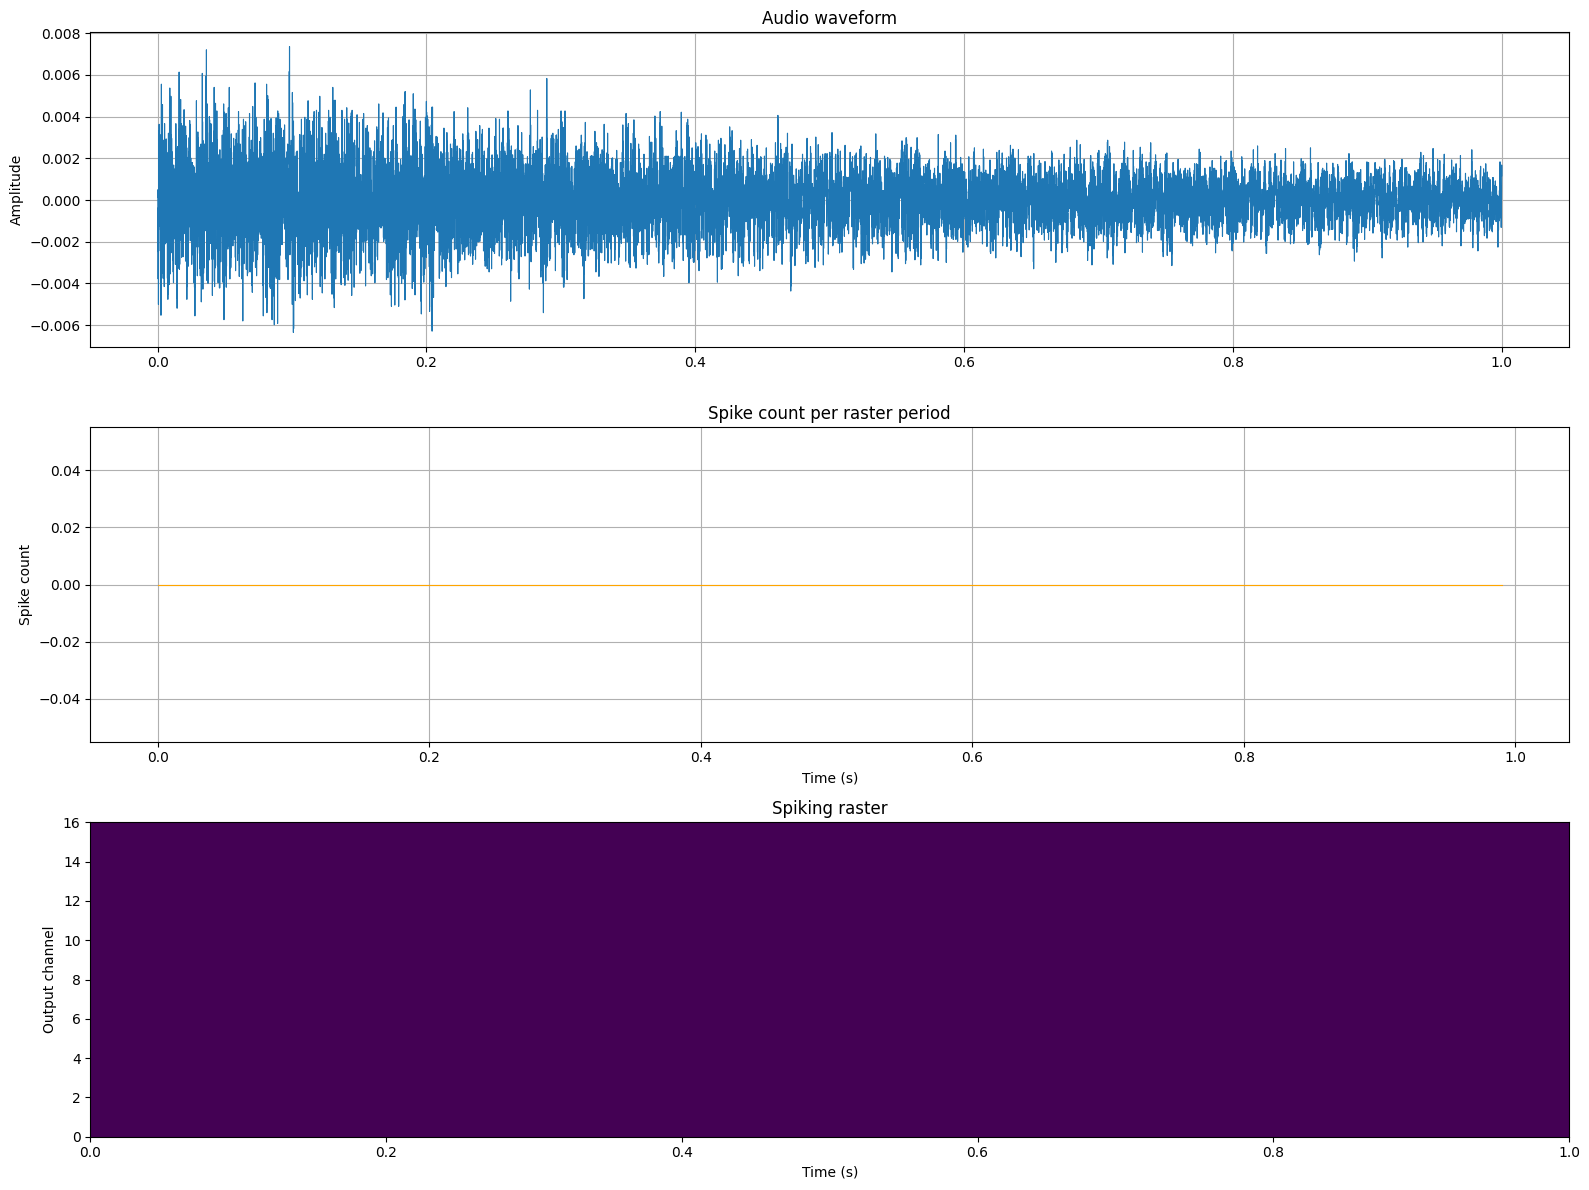

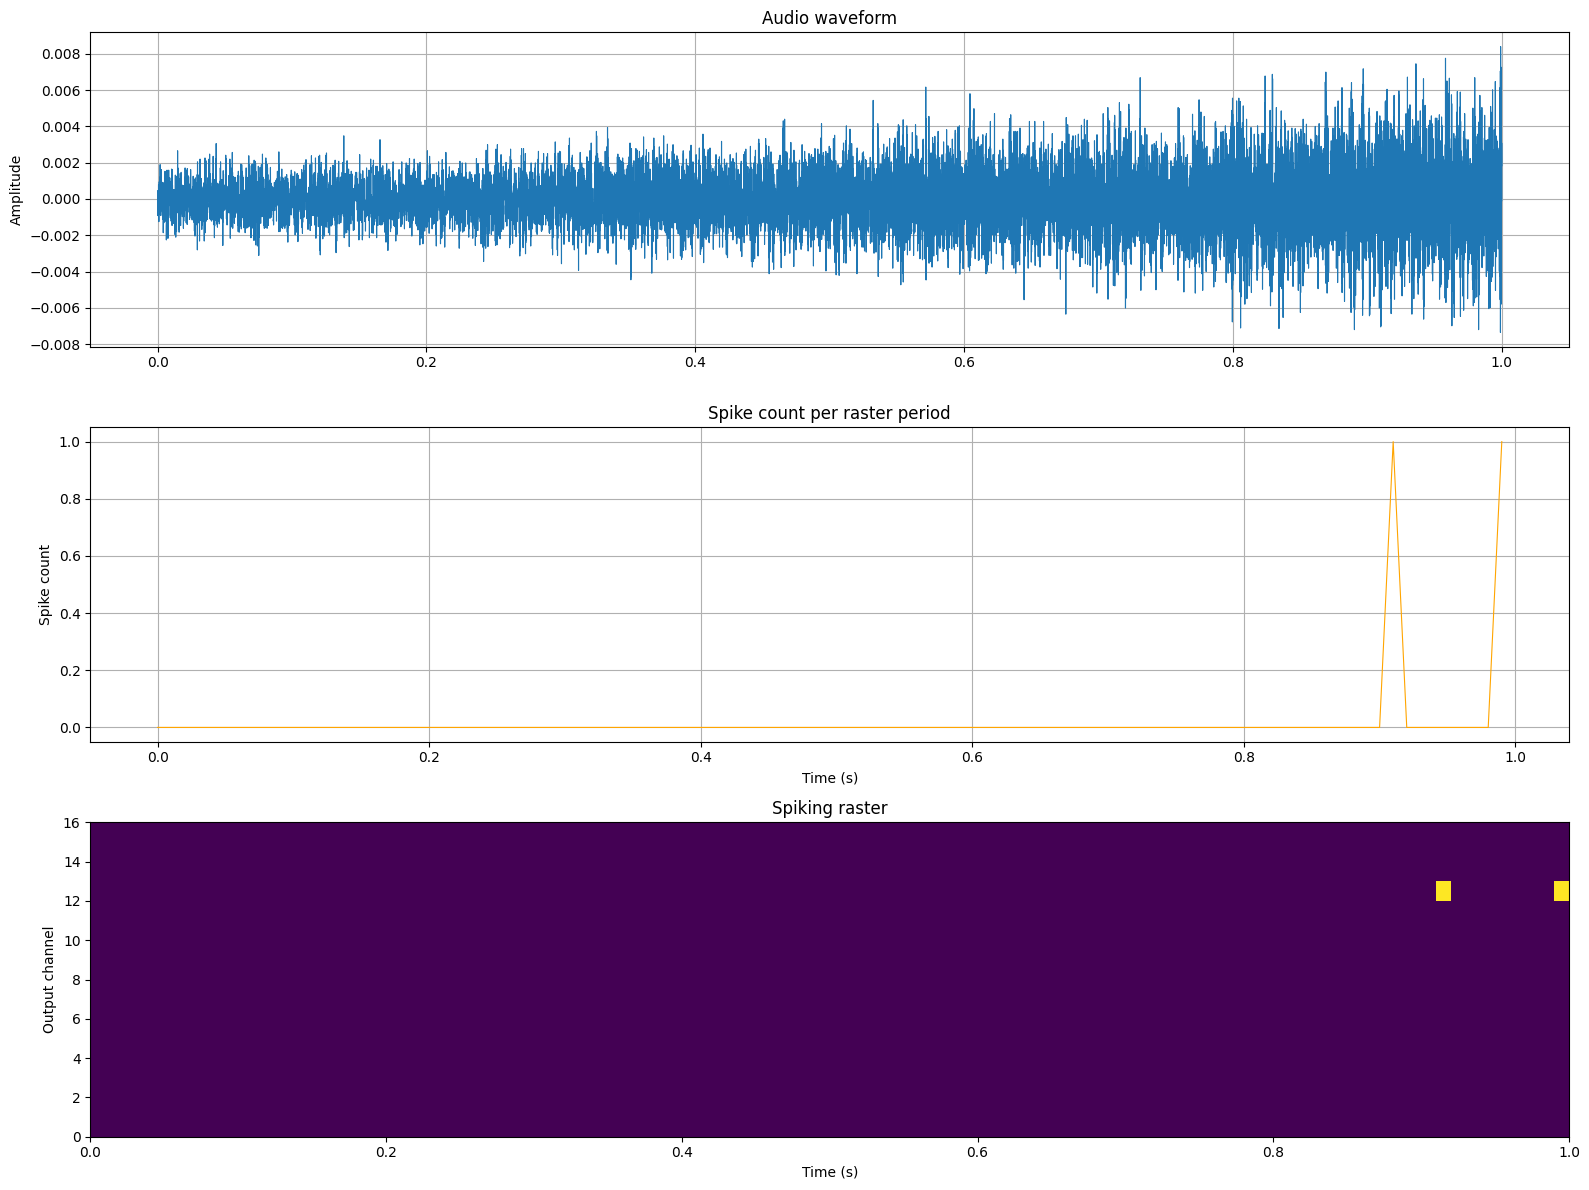

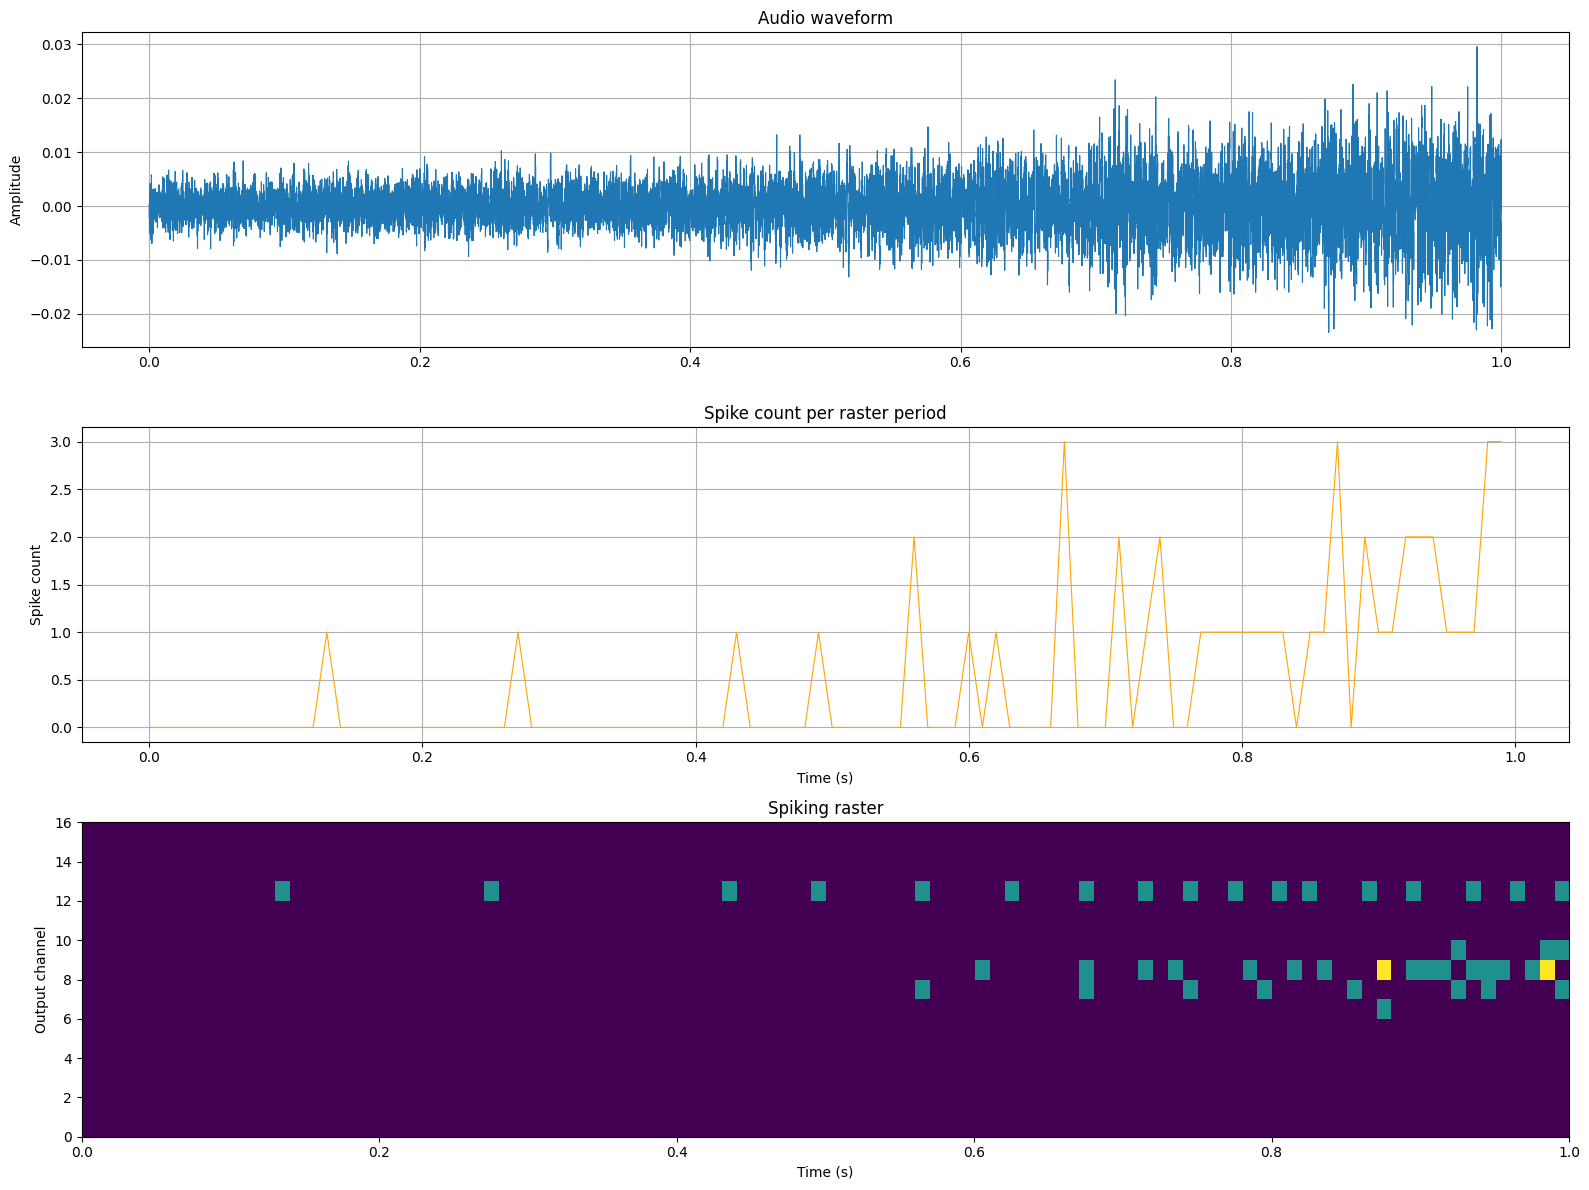

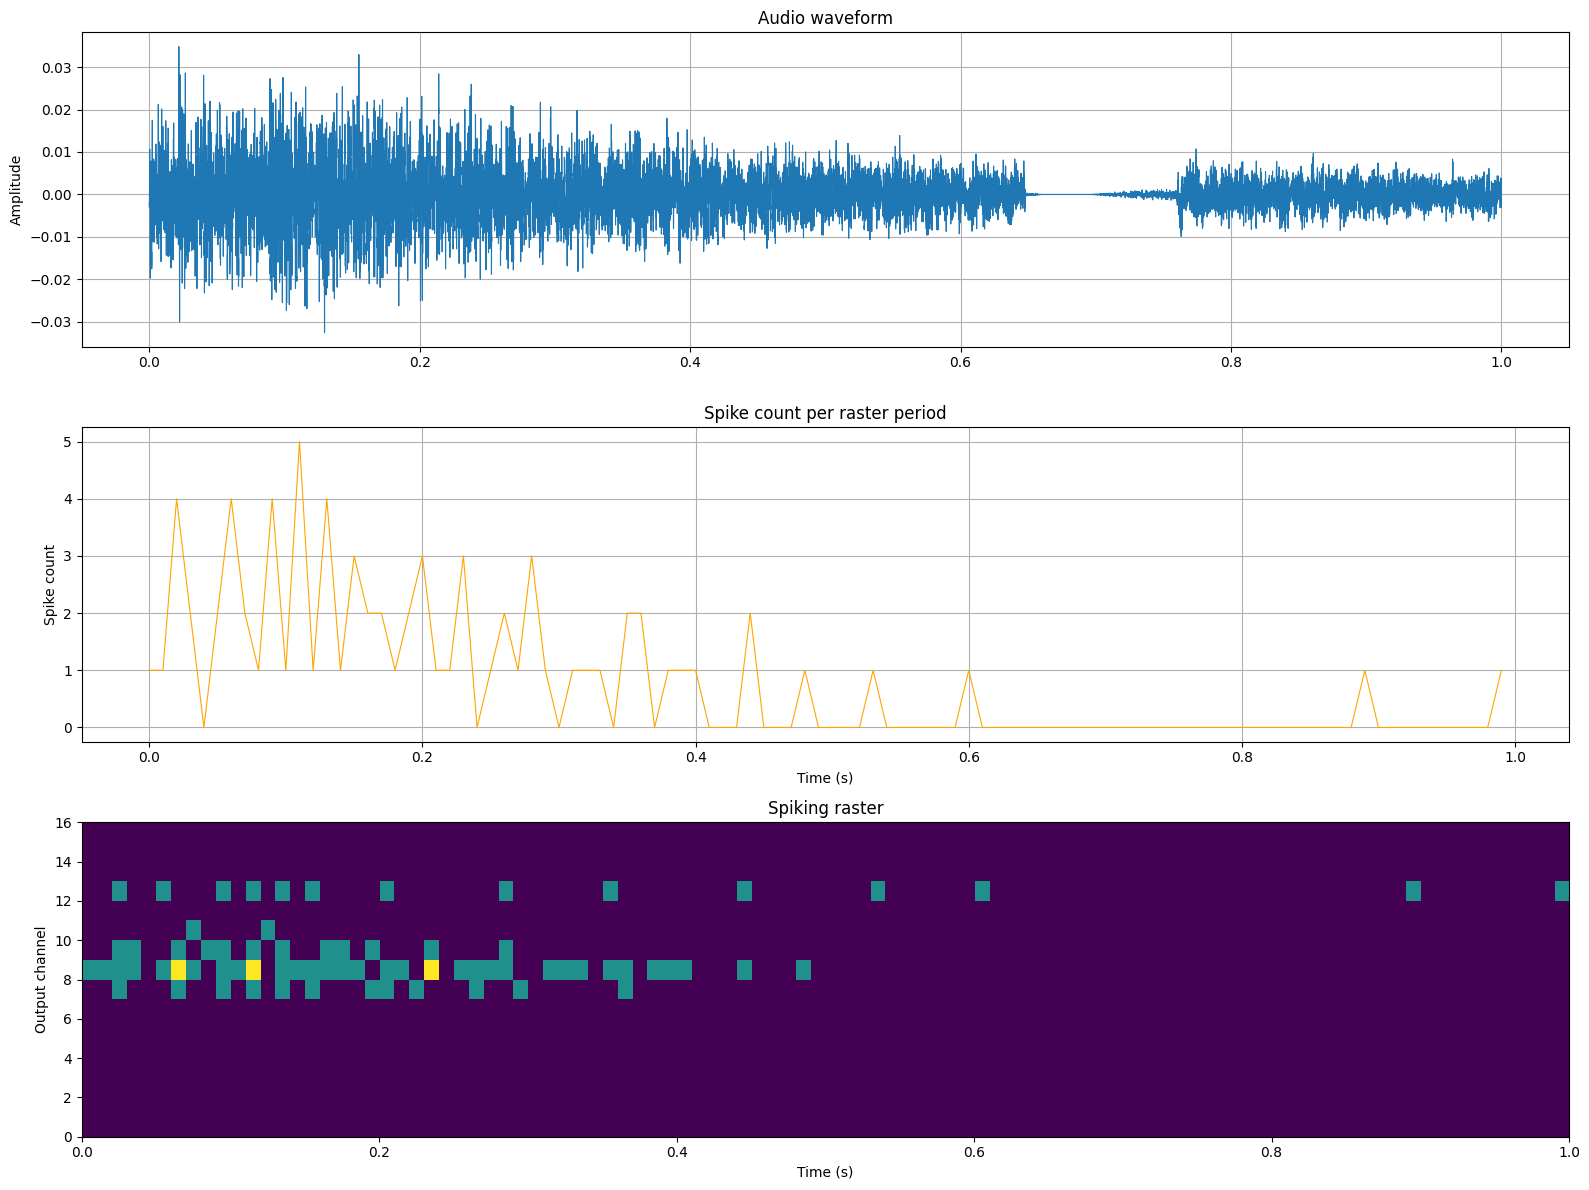

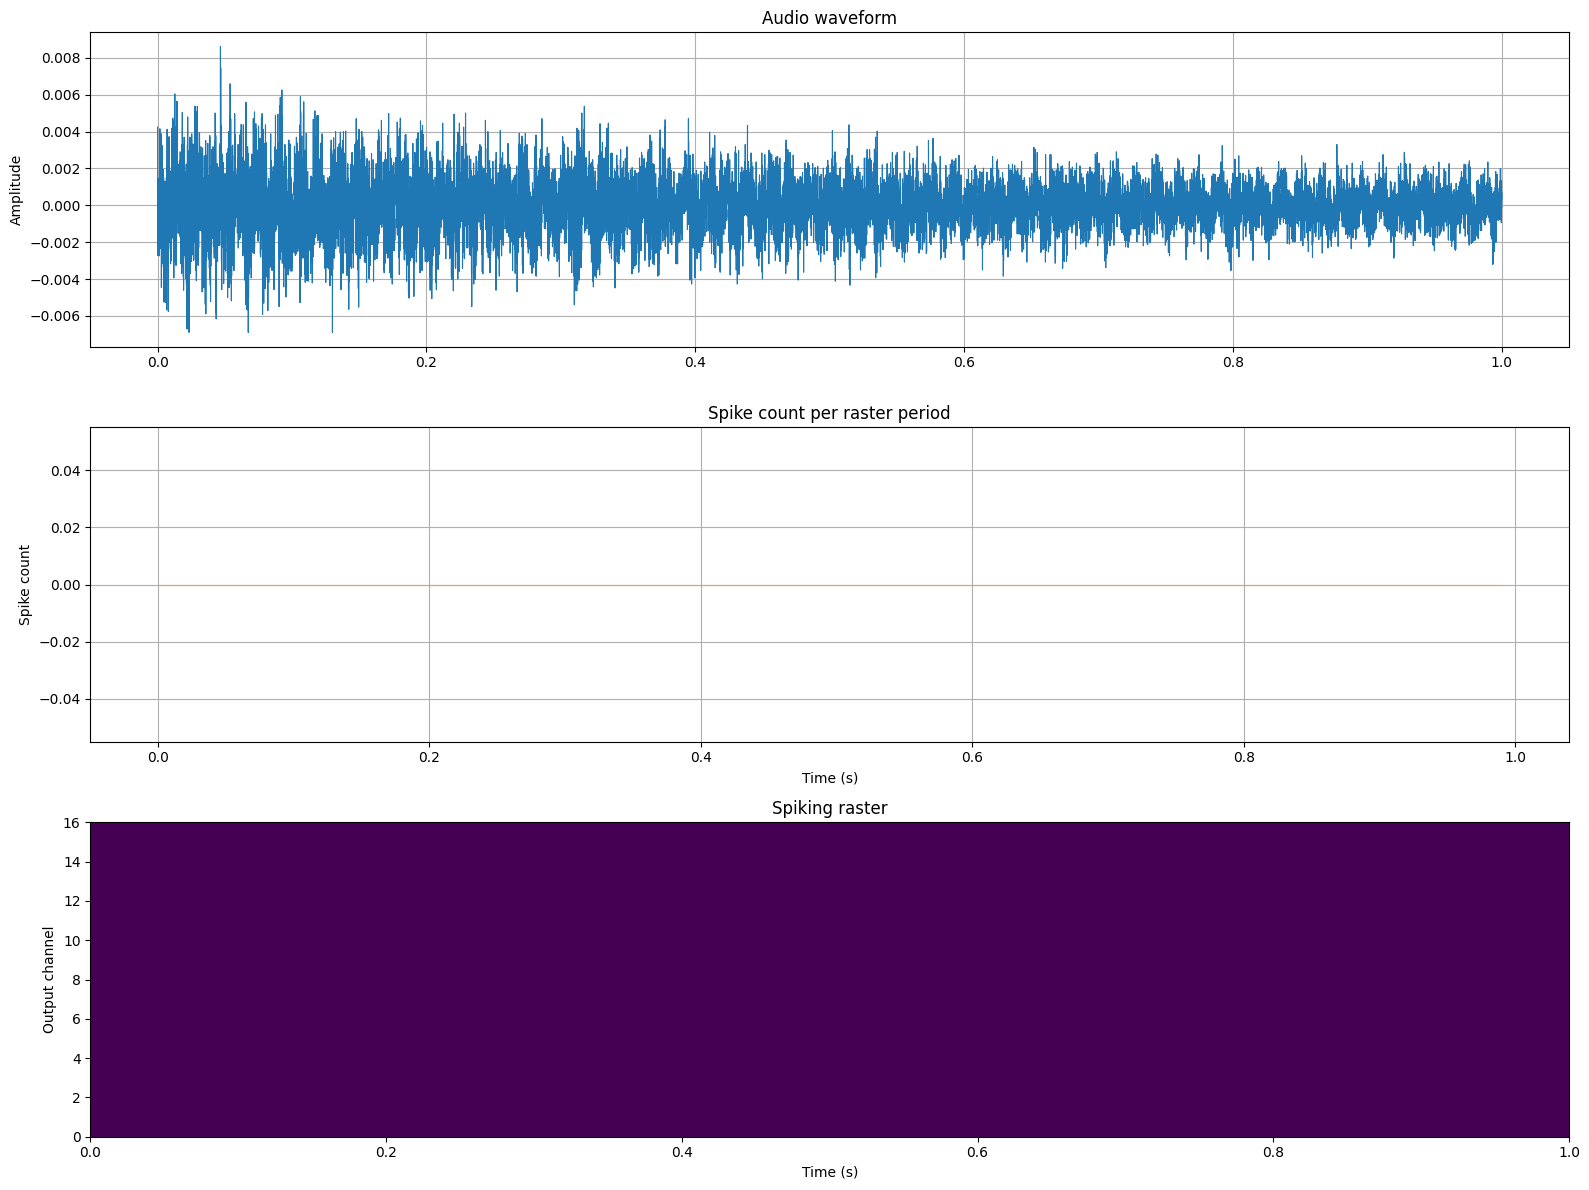

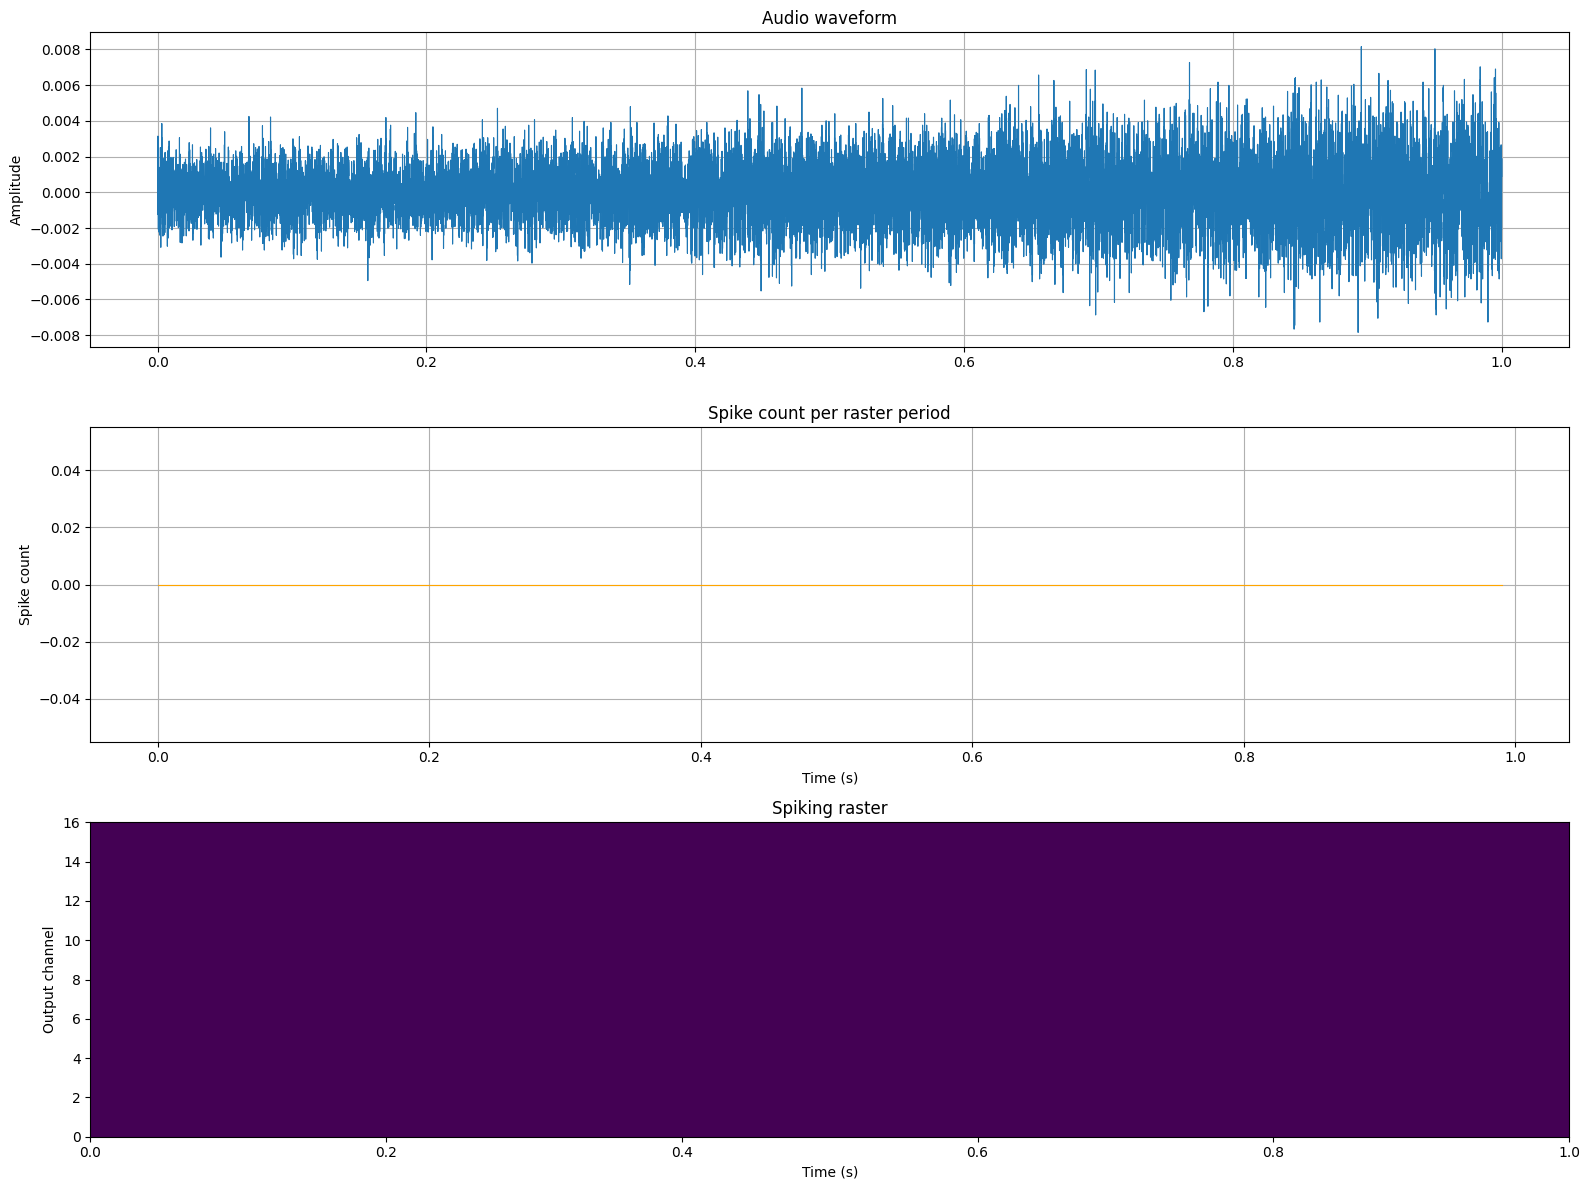

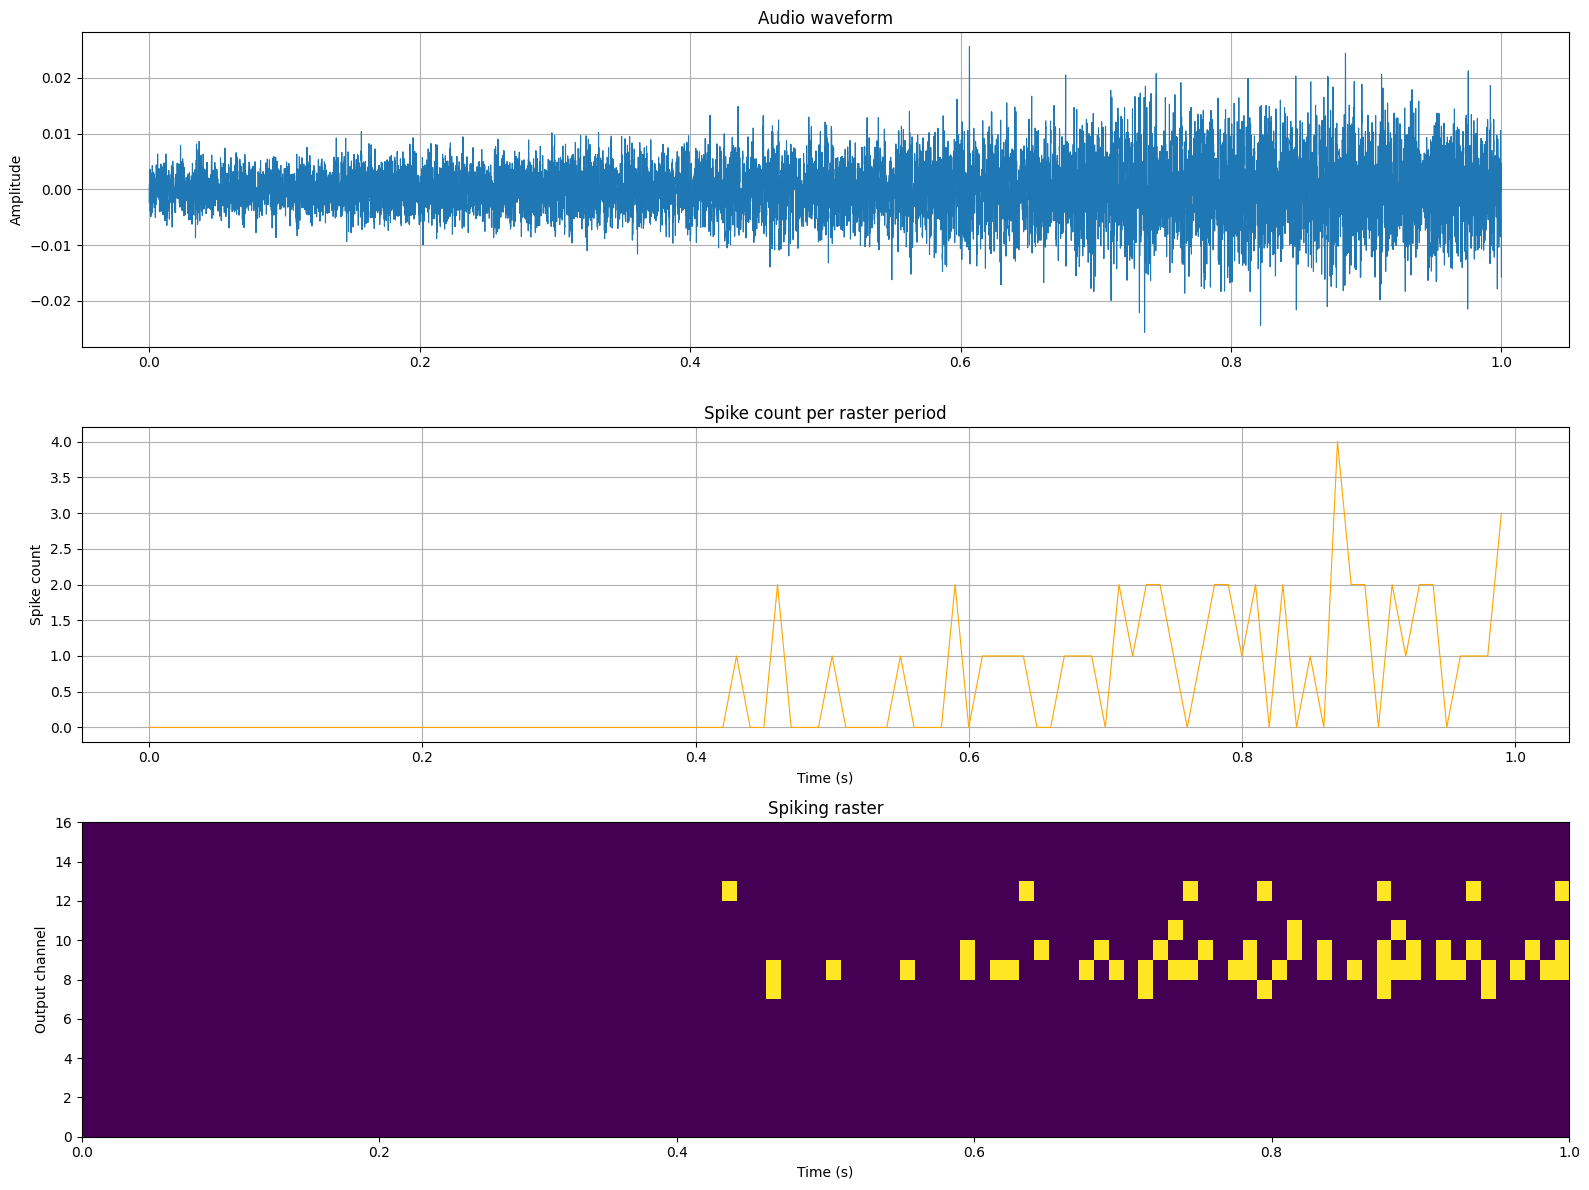

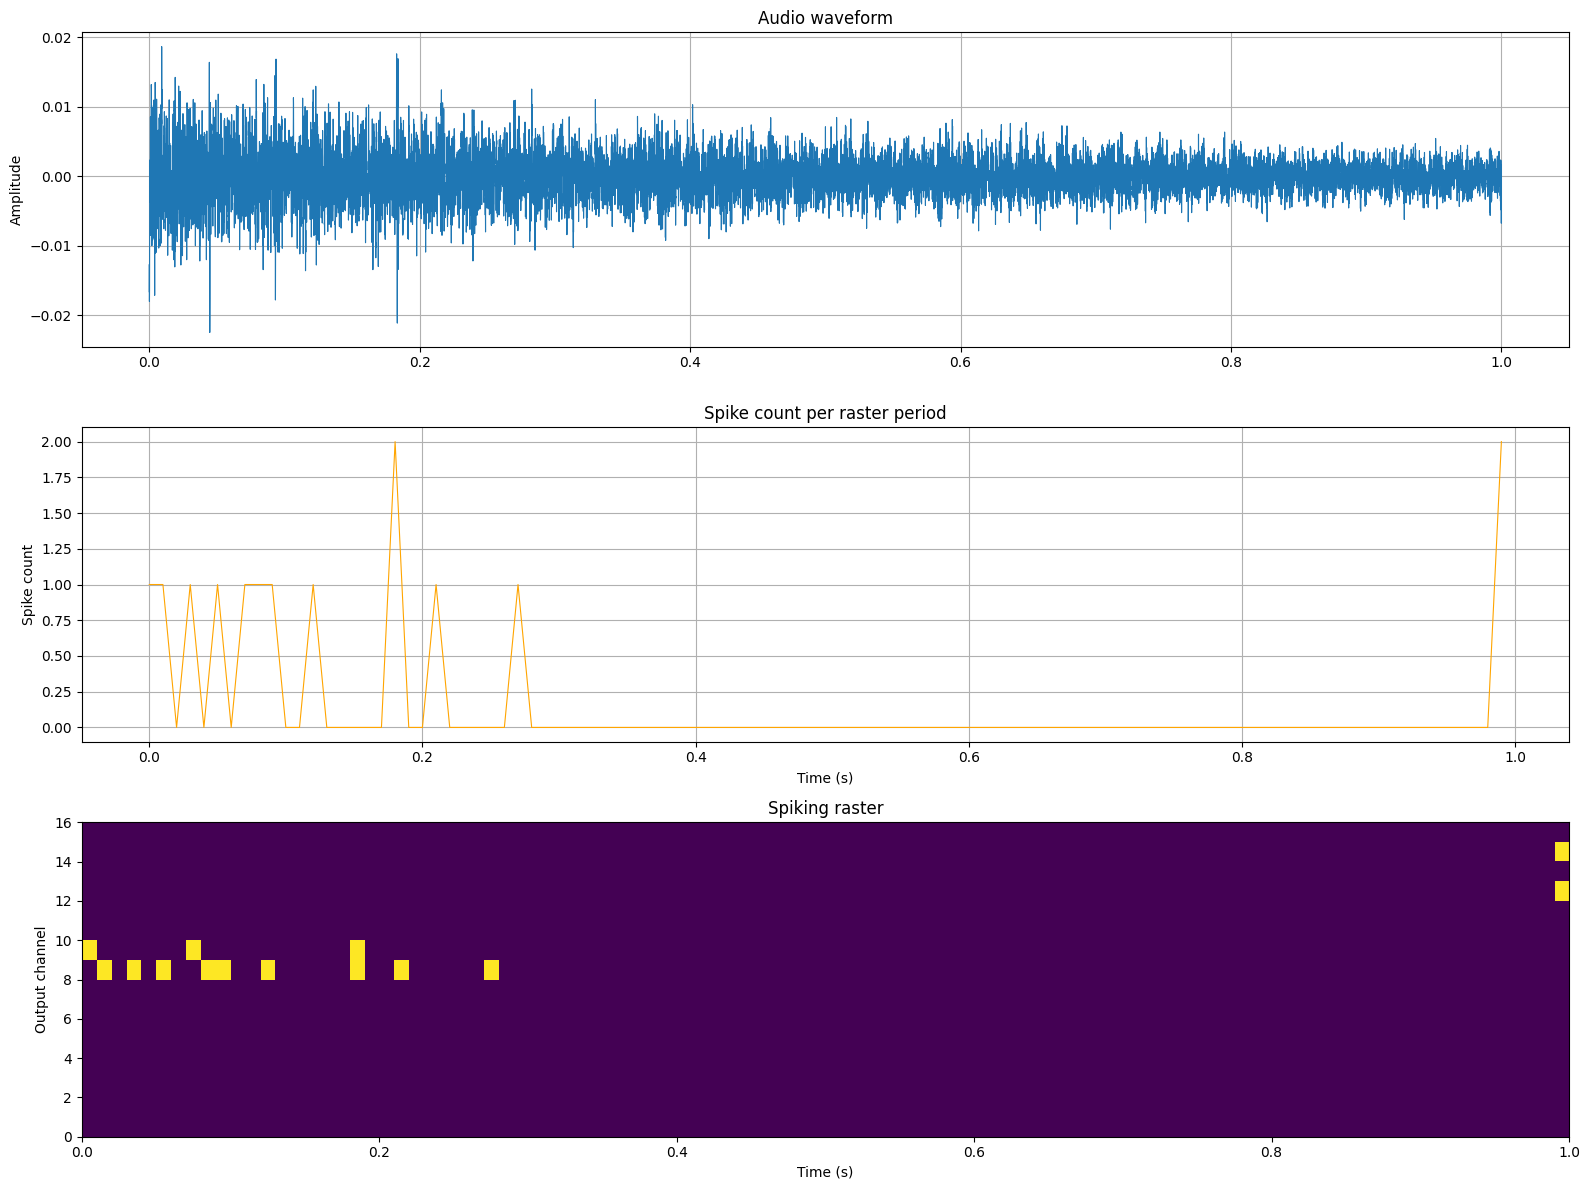

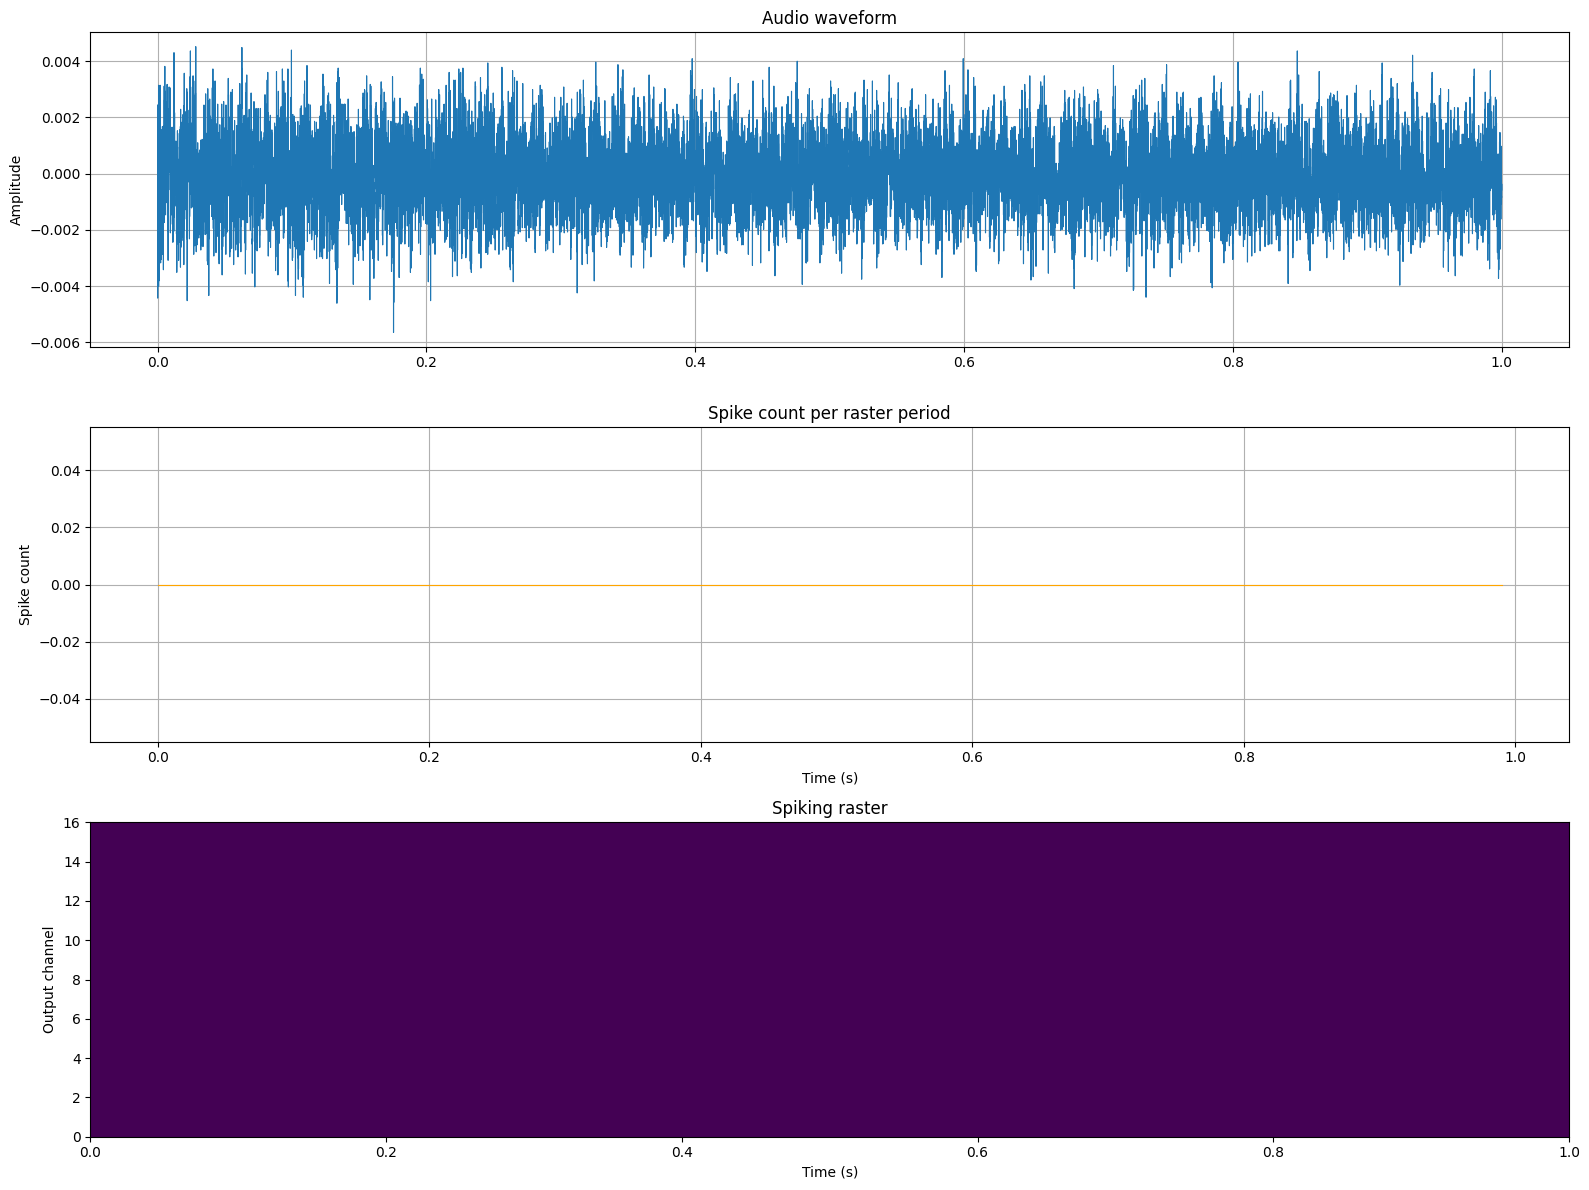

In [ ]:
if __name__ == '__main__':
    logging.basicConfig(
        filename='spike_test.log',
        level=logging.INFO,
        format='%(asctime)s %(levelname)s %(message)s'
    )
    base_dir = os.path.dirname(os.path.abspath('__file__'))
    seg_dir = os.path.join(base_dir, 'vehicle_segments')
    input_csv = os.path.join(seg_dir, 'vehicle_clips.csv')

    spike_dir = os.path.join(base_dir, 'npy')
    os.makedirs(spike_dir, exist_ok=True)

    output_csv = os.path.join(spike_dir, 'spike_labels.csv')

    if not os.path.exists(input_csv):
        logging.error(f"input CSV not found at: {input_csv}")
        exit(1)

    df = pd.read_csv(input_csv)

    # capped to prevent generating large file.
    count = 0
    limit = 30

    with open(output_csv, 'w') as cf:
        cf.write('filepath,label\n')

        for _, row in df.iterrows():
            if count >= 30:
                break
            input_path = row['filepath']
            label = row['label']

            try:
                out_path = audio_to_features(
                    input_path=input_path, output_dir=spike_dir, label=label, plot=True)
                if out_path and validate_npy_file(out_path):
                    cf.write(f"{os.path.basename(out_path)},{label}\n")
            except Exception as e:
                logging.error(f"Failed to process {input_path}: {e}")

            count += 1